# Make plots for the brown bag

In [1]:
%matplotlib inline
import time

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from types import SimpleNamespace
from typing import Tuple, Sequence, Callable, Union, Optional
from tqdm.notebook import tqdm
from mpl_toolkits import axes_grid1

from sklearn import metrics
from scipy.special import erf
from numba import njit

from bioslds.regressors import BioWTARegressor, CrosscorrelationRegressor
from bioslds.plotting import FigureManager, show_latent, colorbar
from bioslds.cluster_quality import calculate_sliding_score, unordered_accuracy_score
from bioslds.dataset import RandomArmaDataset, SwitchingSignal
from bioslds.batch import hyper_score_ar
from bioslds.arma import make_random_arma, Arma
from bioslds.regressor_utils import to_hankel, fit_infer_ar
from bioslds.monitor import AttributeMonitor
from bioslds import sources
from bioslds.arma_hsmm import sample_switching_models
from bioslds.utils import rle_encode

In [2]:
fig_path = os.path.join("..", "figs")

## Useful definitions

### General

In [3]:
def predict_accuracy(armas: tuple, sig: SwitchingSignal) -> float:
    """ Predict accuracy score from ARMA models.
    
    Parameters
    ----------
    armas
        Pair of `Arma` models.
    sig
        Signal generated from the ARMA models.
    
    Returns a predicted value for the expected accuracy score of a
    winner-take-all method.
    """
    a1 = armas[0].a
    a2 = armas[1].a

    diff = a2 - a1

    p = len(a1)
    x = to_hankel(sig.y, p)[p - 1 : -1]
    s = np.dot(diff, x.T)
    prob_seq = 0.5 * (1 + erf(np.abs(s) / np.sqrt(8)))
    
    return np.mean(prob_seq)

In [4]:
def make_gradient_cmap(name: str, c1, c2, **kwargs) -> mpl.colors.Colormap:
    """ Make a colormap that interpolates between two given colors. """
    rgba1 = mpl.colors.to_rgba(c1)
    rgba2 = mpl.colors.to_rgba(c2)

    segments = {
        "red": [[0.0, 0.0, rgba1[0]], [1.0, rgba2[0], 0.0]],
        "green": [[0.0, 0.0, rgba1[1]], [1.0, rgba2[1], 0.0]],
        "blue": [[0.0, 0.0, rgba1[2]], [1.0, rgba2[2], 0.0]],
        "alpha": [[0.0, 0.0, rgba1[3]], [1.0, rgba2[3], 0.0]],
    }

    cmap = mpl.colors.LinearSegmentedColormap(name, segmentdata=segments, **kwargs)
    return cmap

### Cepstral methods

In [5]:
@njit
def givens(a: float, b: float) -> Tuple[float, float]:
    """ Calculate the cosine and sine for a Givens rotation.
    
    The Givens rotation generated here is
    
    G = [[c, s],
         [-s, c]]
         
    and has the property that
    
    [a, b] @ G = [d, 0]
    
    where `abs(d) = sqrt(a * a + b * b)`.
    
    Parameters
    ----------
    a
        First element of vector to rotate.
    b
        Second element of vector to rotate.
    
    Returns a tuple, `(c, s)`, where `c` is the cosine of the rotation
    angle that zeros the second component, and `s` is its sine.
    """
    if b == 0:
        # nothing to do
        c, s = 1, 0
    elif abs(b) >= abs(a):
        # the branching is meant to maximize numerical stability
        t = -a / b
        s = 1 / np.sqrt(1 + t * t)
        c = s * t
    else:
        t = -b / a
        c = 1 / np.sqrt(1 + t * t)
        s = c * t

    return c, s

In [6]:
@njit
def update_lq_add_col_econ(
    l: np.ndarray, v: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """ Calculate how the non-zero part of the L term in an LQ decomposition changes
    when appending a column.
    
    This is only for the case in which the number of columns is at least as large as
    the number of fows.
    
    This avoids recalculating the full LQ decomposition, and avoids updating the `q`
    matrix altogether. The `l` matrix must be the square, non-zero portion of the L
    term.
    
    Parameters
    ----------
    l
        The L term in the LQ decomposition of some matrix `A`. This must be a square
        matrix.
    v
        The elements of the row to add.
    
    Returns the value of the updated L term after appending the given column to `A`.
    Note that the input argument `l` is left untouched.
    """
    # make sure none of the inputs are changed
    l = np.copy(l)
    v = np.copy(v)

    m = l.shape[0]

    c = np.zeros(m)
    s = np.zeros(m)

    # using algorithms 2.6 and 2.7 from
    # http://eprints.ma.man.ac.uk/1192/1/qrupdating_12nov08.pdf
    # transposing to get LQ instead of QR
    for i in range(m):
        c[i], s[i] = givens(l[i, i], v[i])
        l[i, i] = c[i] * l[i, i] - s[i] * v[i]

        t1 = np.copy(l[i + 1 :, i])
        t2 = v[i + 1 :]

        l[i + 1 :, i] = c[i] * t1 - s[i] * t2
        v[i + 1 :] = s[i] * t1 + c[i] * t2

    return l

In [7]:
class LQCepstralNorm(object):
    """ Calculate cepstral norm online using an LQ decomposition.
    
    This assumes that the input data has zero mean.
    
    This works by updating the L part of the LQ decomposition of the future and total
    Hankel matrices. The update first discounts all old samples by multiplying the
    (implicit) Hankel matrices by a discount factor (`gamma`), and then adds a column
    corresponding to the new samples. The cepstral norm is calculated from the
    diagonal elements of the L matrices for the full and future Hankel matrices,
    using a version of the method from De Cock, 2002.
    
    Attributes
    ----------
    order : int
        Number of cepstral coefficients to use, which is equivalent to the number of
        rows in the past and future Hankel matrices.
    gamma : float
        Discount factor.
    norm : float
        Current estimate of the cepstral norm.
    l : np.ndarray
        Current estimate of the L factor for the total Hankel matrix.
    l_future : np.ndarray
        Current estimate of the L factor for the future Hankel matrix.
    """

    def __init__(self, order: int, gamma: float):
        """ Initialize the cepstral norm calculator.
        
        Parameters
        ----------
        order
            The number of cepstral coefficients to use. Note that the zeroth order
            coefficient is always ignored, so this counts from the first coefficient
            onwards.
        gamma
            Discount factor.
        """
        self.order = order
        self.gamma = gamma

        # precalculate some useful parameters
        self._window = 2 * order
        self._alpha = np.sqrt(1 - self.gamma ** 2)
        
        self.init()
    
    def init(self):
        # initialze the cepstral norm estimate
        self.norm = 0
        
        # initialize the L factor estimates
        self.l = self._alpha * np.eye(2 * self.order)
        self.l_future = self._alpha * np.eye(self.order)

        # initialize the history vector needed for the calculations
        self._history = np.zeros(2 * self.order)

    def feed(self, x: float) -> float:
        """ Process a sample.
        
        The cepstral-norm estimate assumes that the input data has zero mean.
        
        Parameters
        ----------
        x
            A new sample to use to update the cepstral norm estimate.
        
        Returns the current estimate of the cepstral norm. This is also stored in `self.norm`.
        """
        # add the sample to the history
        self._history[:-1] = self._history[1:]
        self._history[-1] = x

        # apply the discount factor
        self.l *= self.gamma

        # ...then add a column to the Hankel matrix
        v = self._alpha * self._history
        self.l = update_lq_add_col_econ(self.l, v)

        v_future = v[self.order :]
        self.l_future *= self.gamma
        self.l_future = update_lq_add_col_econ(self.l_future, v_future)

        self._update_norm()
        return self.norm

    def process(self, sig: Sequence, progress: Callable = None) -> np.ndarray:
        """ Process a time series.
        
        Parameters
        ----------
        sig
            Time series data.
        progress
            A function that can be applied to an iterable to generate a progress bar. An
            example is the bar from the package `tqdm`.
        
        Returns an array of cepstral-norm estimates at each time step.
        """
        norms = np.zeros_like(sig)
        iterable = range(len(sig))
        if progress is not None:
            iterable = progress(iterable)
        for i in iterable:
            norms[i] = self.feed(sig[i])
        
        return norms

    def _update_norm(self):
        """ Calculate cepstral norm using current L-factor estimates. """
        l_all_terms = np.log(np.abs(np.diag(self.l)))
        l_neg_terms = l_all_terms[self.order :]
        
        # this is the corrected formula from De Cock's thesis
        l_pos_terms = np.log(np.abs(np.diag(self.l_future)))

        self.norm = 2 * np.sum(l_pos_terms - l_neg_terms)

In [8]:
class CepstralOracleRegressor(object):
    """ A class implementing an oracle-like regressor based on the cepstral norm.
    
    Specifically, consider an output (dependent) signal `y` given by a time-dependent
    linear function of an input (predictor) signal `x`,
        y[t] = sum_k z[t][k] * np.dot(w[k, :], x[t]) ,
    where `z[t]` is a one-hot encoding of the model used at time `t` (`z[t][k] == 1` iff
    model `k` is used, 0 else) and `x[t]` is a lag vector, `x[t][i] = y[t - i - 1]`.

    This class assumes that the coefficients `w` are known (hence the oracle character)
    and uses the inverse (MA) processes to filter the input `y`. The filter that outputs
    the most uncorrelated samples indicates the likely generating processes. The level
    of correlation is assessed using a cepstral norm calculated online (see
    `LQCepstralNorm`).

    Attributes
    ==========
    n_models : int
        Number of models in mixture.
    n_features : int
        Order for cepstral norm (see `LQCepstralNorm`).
    models : Sequence[Arma]
        The models that generated the sequence.
    inverse_models : Sequence[Arma]
        The filters that can be used to invert the `models`.
    cepstral : LQCepstralNorm
        The object calculating the cepstral norm.
    """

    def __init__(
        self,
        models: Sequence[Arma],
        n_features: int,
        cepstral_rate: Union[float, Sequence, Callable[[float], float]] = 0.02,
        cepstral_kws: Optional[dict] = None,
    ):
        """ Initialize the segmentation model.

        Parameters
        ----------
        models
            The models that generated the mixture.
        n_features
            Order for cepstral norm (see `LQCepstralNorm`).
        cepstral_rate
            Learning rate for the cepstral norm calculator. This is `1 - gamma`, where
            `gamma` is the discount factor from `LQCepstralNorm`.
        cepstral_kws
            Additional keyword arguments to pass to `LQCepstralNorm.__init__`.
        """
        self.n_models = len(models)
        self.n_features = n_features

        self.models = models
        self.inverse_models = [_.inverse() for _ in self.models]

        if cepstral_kws is None:
            cepstral_kws = {}
        else:
            cepstral_kws = copy.copy(cepstral_kws)
        cepstral_kws.setdefault("gamma", 1 - cepstral_rate)
        self.cepstral = [
            LQCepstralNorm(self.n_features, **cepstral_kws)
            for _ in range(self.n_models)
        ]

    def fit_infer(
        self,
        X: Sequence,
        y: Sequence,
        progress: Optional[Callable] = None,
        monitor: Union[None, AttributeMonitor, Sequence] = None,
        chunk_hint: int = 1000,
    ) -> Union[np.ndarray, Tuple[np.ndarray, SimpleNamespace]]:
        """ Feed a set of samples through the model, inferring which model fits best at
        each time step.

        Parameters
        ----------
        X
            This is not used.
        y
            The values of the time series to segment; shape `(n_samples,)`.
        progress
            Progress function that can be used either as a wrapper or manually, like
            `tqdm.tqdm`. Specifically, this needs to support wrapping an iterable, so
            you can write, e.g., `for x in progress(X): ...`; and it needs to support
            calling with a `total` argument, an `update`, and a `close` method, e.g.:
                pbar = progress(total=100)
                for i in range(100):
                    pbar.update(1)  # note that arg is step (=1), not i!
                pbar.close()
        monitor
            This can be an object for monitoring the evolution of the parameters during
            learning (e.g., an instance of `AttributeMonitor`), or a sequence of
            attribute names indicating the parameters to be tracked. If the latter, the
            function generates an `AttributeMonitor`. In either case, the monitor's
            `history_` is returned as a second return value. Parameter values are stored
            and calculated before their updates.
        chunk_hint
            A hint about how to chunk the learning. This may or may not be used. If it
            is, the progress function will only be called once per chunk.

        If `monitor` is not provided: returns an array `r` with shape `(n_samples,
        n_models)` such  that `r[t, k]` shows, roughly, how likely it is that the sample
        at time `t` was generated by model `k`. Note that this is not a probabilistic
        model, so this should not be taken literally. These values are calculated as
        minus the cepstral norms obtained when each model's inverse is used as a filter.

        If a `monitor` is used: returns a tuple `(r, history)` where `r` is the output
        from above, and `history` is the `history_` attribute of the monitor that was
        used. When an `AttributeMonitor` is used (which is what happens when `monitor`
        is a sequence), the `history` output behaves like a `SimpleNamespace`, where
        each tracked attribute is a member.
        """
        # handle progress function
        n = len(y)
        if progress is not None:
            pbar = progress(total=n)
        else:
            pbar = None

        if monitor is not None:
            raise NotImplementedError("no monitoring yet")
            if hasattr(monitor, "__len__") and not hasattr(monitor, "setup"):
                monitor = AttributeMonitor(monitor)
            monitor.setup(n)

        out = np.zeros((n, self.n_models))
        for k, inv_model in enumerate(self.inverse_models):
            # start from a blank slate
            inv_model.history_ = (np.zeros(inv_model.p), np.zeros(inv_model.q))
            self.cepstral[k].init()

        for chunk_start in range(0, n, chunk_hint):
            crt_range = slice(chunk_start, chunk_start + chunk_hint)
            #             crt_x = X[crt_range]
            crt_y = y[crt_range]
            crt_out = out[crt_range]
            crt_n = len(crt_y)

            #             if monitor is not None:
            #                 xcorr_monitor = AttributeMonitor(
            #                     [_[6:] for _ in monitor.names if _.startswith("xcorr.")]
            #                 )
            #                 nsm_monitor = AttributeMonitor(
            #                     [_[4:] for _ in monitor.names if _.startswith("nsm.")]
            #                 )
            #             else:
            #                 xcorr_monitor = None
            #                 nsm_monitor = None

            filtered = np.zeros((self.n_models, crt_n))
            for k, inv_model in enumerate(self.inverse_models):
                filtered[k, :] = inv_model.transform(U=crt_y)[0]
                crt_out[:, k] = -self.cepstral[k].process(filtered[k, :])

            #             if monitor is not None:
            #                 # combine
            #                 obj = SimpleNamespace(
            #                     xcorr=xcorr_monitor.history_, nsm=nsm_monitor.history_
            #                 )
            #                 monitor.record_batch(obj)

            if pbar is not None:
                pbar.update(crt_n)

        if pbar is not None:
            pbar.close()

        if monitor is None:
            return out
        else:
            return out, monitor.history_

In [9]:
class OnlineVariance(object):
    """ Calculate local estimate of variance.
    
    This assumes that the input data has zero mean.
    
    Attributes
    ----------
    rate : float
        Learning rate.
    var_ : float
        Current estimate of the variance.
    """

    def __init__(self, rate: float):
        """ Initialize the cepstral norm calculator.
        
        Parameters
        ----------
        rate
            Learning rate.            
        """
        self.rate_ = rate

        self.init()

    def init(self):
        self.var_ = 0

    def process(self, sig: Sequence) -> np.ndarray:
        """ Process a time series.
        
        Parameters
        ----------
        sig
            Time series data.
        
        Returns an array of variance estimates at each time step.
        """
        if len(sig) == 0:
            return np.array([])

        sig = np.asarray(sig)
        res = np.zeros_like(sig)
        _numba_var_process(sig, res, self.var_, self.rate_)

        self.var_ = res[-1]
        return res


@njit
def _numba_var_process(y: np.ndarray, var_history: np.ndarray, var: float, rate: float):
    n = len(y)
    for i in range(n):
        var_history[i] = var
        crt_y = y[i]

        var += rate * (crt_y ** 2 - var)

In [10]:
class AverageErrorRegressor(object):
    """ A class implementing an oracle-like regressor based on locally averaged RMSD.
    
    Specifically, consider an output (dependent) signal `y` given by a time-dependent
    linear function of an input (predictor) signal `x`,
        y[t] = sum_k z[t][k] * np.dot(w[k, :], x[t]) ,
    where `z[t]` is a one-hot encoding of the model used at time `t` (`z[t][k] == 1` iff
    model `k` is used, 0 else) and `x[t]` is a lag vector, `x[t][i] = y[t - i - 1]`.

    This class assumes that the coefficients `w` are known (hence the oracle character)
    and uses the inverse (MA) processes to filter the input `y`. The filter that outputs
    the most uncorrelated samples indicates the likely generating processes. This should
    also be the filter that returns the signal with lowest variance. The value of this
    (locally estimated) variance is used to indicate how well each model works.

    Attributes
    ==========
    n_models : int
        Number of models in mixture.
    models : Sequence[Arma]
        The models that generated the sequence.
    inverse_models : Sequence[Arma]
        The filters that can be used to invert the `models`.
    variance_estimators : Sequence[OnlineVariance]
        The objects calculating the local variance of the prediction error.
    """

    def __init__(
        self,
        models: Sequence[Arma],
        variance_rate: float = 0.02,
        variance_kws: Optional[dict] = None,
    ):
        """ Initialize the segmentation model.

        Parameters
        ----------
        models
            The models that generated the mixture.
        variance_rate
            Learning rate for the variance estimator.
        variance_kws
            Additional keyword arguments to pass to `OnlineVariance.__init__`.
        """
        self.n_models = len(models)
        self.n_features = 1

        self.models = models
        self.inverse_models = [_.inverse() for _ in self.models]

        if variance_kws is None:
            variance_kws = {}
        else:
            variance_kws = copy.copy(variance_kws)
        variance_kws.setdefault("rate", variance_rate)
        self.variance_estimators = [
            OnlineVariance(**variance_kws) for _ in range(self.n_models)
        ]

    def fit_infer(
        self,
        X: Sequence,
        y: Sequence,
        progress: Optional[Callable] = None,
        monitor: Union[None, AttributeMonitor, Sequence] = None,
        chunk_hint: int = 1000,
    ) -> Union[np.ndarray, Tuple[np.ndarray, SimpleNamespace]]:
        """ Feed a set of samples through the model, inferring which model fits best at
        each time step.

        Parameters
        ----------
        X
            This is not used.
        y
            The values of the time series to segment; shape `(n_samples,)`.
        progress
            Progress function that can be used either as a wrapper or manually, like
            `tqdm.tqdm`. Specifically, this needs to support wrapping an iterable, so
            you can write, e.g., `for x in progress(X): ...`; and it needs to support
            calling with a `total` argument, an `update`, and a `close` method, e.g.:
                pbar = progress(total=100)
                for i in range(100):
                    pbar.update(1)  # note that arg is step (=1), not i!
                pbar.close()
        monitor
            This can be an object for monitoring the evolution of the parameters during
            learning (e.g., an instance of `AttributeMonitor`), or a sequence of
            attribute names indicating the parameters to be tracked. If the latter, the
            function generates an `AttributeMonitor`. In either case, the monitor's
            `history_` is returned as a second return value. Parameter values are stored
            and calculated before their updates.
        chunk_hint
            A hint about how to chunk the learning. This may or may not be used. If it
            is, the progress function will only be called once per chunk.

        If `monitor` is not provided: returns an array `r` with shape `(n_samples,
        n_models)` such  that `r[t, k]` shows, roughly, how likely it is that the sample
        at time `t` was generated by model `k`. Note that this is not a probabilistic
        model, so this should not be taken literally. These values are calculated as
        minus the cepstral norms obtained when each model's inverse is used as a filter.

        If a `monitor` is used: returns a tuple `(r, history)` where `r` is the output
        from above, and `history` is the `history_` attribute of the monitor that was
        used. When an `AttributeMonitor` is used (which is what happens when `monitor`
        is a sequence), the `history` output behaves like a `SimpleNamespace`, where
        each tracked attribute is a member.
        """
        # handle progress function
        n = len(y)
        if progress is not None:
            pbar = progress(total=n)
        else:
            pbar = None

        if monitor is not None:
            raise NotImplementedError("no monitoring yet")
            if hasattr(monitor, "__len__") and not hasattr(monitor, "setup"):
                monitor = AttributeMonitor(monitor)
            monitor.setup(n)

        out = np.zeros((n, self.n_models))
        for k, inv_model in enumerate(self.inverse_models):
            # start from a blank slate
            inv_model.history_ = (np.zeros(inv_model.p), np.zeros(inv_model.q))
            self.variance_estimators[k].init()

        for chunk_start in range(0, n, chunk_hint):
            crt_range = slice(chunk_start, chunk_start + chunk_hint)
            #             crt_x = X[crt_range]
            crt_y = y[crt_range]
            crt_out = out[crt_range]
            crt_n = len(crt_y)

            #             if monitor is not None:
            #                 xcorr_monitor = AttributeMonitor(
            #                     [_[6:] for _ in monitor.names if _.startswith("xcorr.")]
            #                 )
            #                 nsm_monitor = AttributeMonitor(
            #                     [_[4:] for _ in monitor.names if _.startswith("nsm.")]
            #                 )
            #             else:
            #                 xcorr_monitor = None
            #                 nsm_monitor = None

            filtered = np.zeros((self.n_models, crt_n))
            for k, inv_model in enumerate(self.inverse_models):
                filtered[k, :] = inv_model.transform(U=crt_y)[0]
                crt_out[:, k] = -self.variance_estimators[k].process(filtered[k, :])

            #             if monitor is not None:
            #                 # combine
            #                 obj = SimpleNamespace(
            #                     xcorr=xcorr_monitor.history_, nsm=nsm_monitor.history_
            #                 )
            #                 monitor.record_batch(obj)

            if pbar is not None:
                pbar.update(crt_n)

        if pbar is not None:
            pbar.close()

        if monitor is None:
            return out
        else:
            return out, monitor.history_

## Sketch how mis-identified samples occur

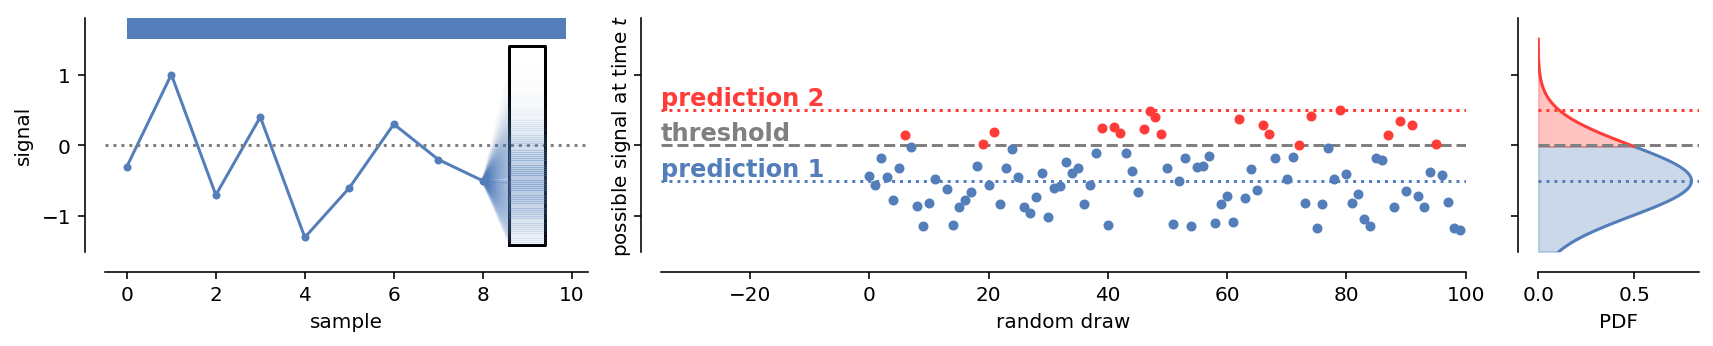

In [11]:
with FigureManager(
    1, 3, gridspec_kw={"width_ratios": (3, 5, 1)}, sharey=True, figsize=(12, 2.5)
) as (
    fig,
    (ax0, ax1, ax2),
):
    crt_sigma = 0.5
    crt_pred1 = -crt_sigma
    crt_pred2 = crt_sigma

    crt_thresh = 0.5 * (crt_pred1 + crt_pred2)
    
    crt_samples = [-0.3, 1.0, -0.7, 0.4, -1.3, -0.6, 0.3, -0.2, -0.5]
    crt_n = len(crt_samples)
    crt_usage = np.zeros(crt_n + 1, dtype=int)
    ax0.plot(crt_samples, ".-", c="C0")
    ax0.axhline(0, ls=":", c="gray")

    crt_box = [[crt_n - 0.4, crt_n + 0.4], [-1.4, 1.4]]
    ax0.plot(
        crt_box[0] + crt_box[0][::-1] + [crt_box[0][0]],
        [crt_box[1][0]] + crt_box[1] + crt_box[1][::-1],
        "k-",
    )

    crt_p_range = (-1.5, 1.5)
    ax0.set_ylim(*crt_p_range)
    ax0.set_xlabel("sample")
    ax0.set_ylabel("signal")

    show_latent(crt_usage, ax=ax0)

    crt_ps = np.linspace(*crt_p_range, 100)
    crt_dist = (
        1
        / np.sqrt(2 * np.pi * crt_sigma ** 2)
        * np.exp(-0.5 * ((crt_ps - crt_pred1) / crt_sigma) ** 2)
    )
    for crt_y, crt_p in zip(crt_ps, crt_dist):
        if crt_y < crt_box[1][0] or crt_y >= crt_box[1][1]:
            continue
        ax0.plot(
            [crt_n - 1, crt_box[0][0]],
            [crt_samples[-1], crt_y],
            c="C0",
            alpha=0.5 * crt_p,
        )
        ax0.plot(
            [crt_box[0][0] + 0.01, crt_box[0][1] - 0.01],
            [crt_y, crt_y],
            c="C0",
            alpha=0.5 * crt_p,
        )

    crt_col1 = "C0"
    crt_col2 = "C1"
    crt_col_err1 = "C1"
    crt_col_err2 = "C4"

    ax1.axhline(crt_pred1, c=crt_col1, ls=":")
    ax1.axhline(crt_pred2, c=crt_col2, ls=":")
    ax1.axhline(crt_thresh, c="gray", ls="--")

    rng = np.random.default_rng(0)
    crt_n = 100
    crt_samples1 = rng.normal(crt_pred1, crt_sigma, size=crt_n)
    # crt_samples2 = rng.normal(crt_pred2, crt_sigma, size=crt_n)

    crt_correct1 = crt_samples1 < crt_thresh
    crt_idxs = np.arange(crt_n)
    crt_ms = 8
    ax1.plot(
        crt_idxs[crt_correct1], crt_samples1[crt_correct1], ".", c=crt_col1, ms=crt_ms
    )
    ax1.plot(
        crt_idxs[~crt_correct1],
        crt_samples1[~crt_correct1],
        ".",
        c=crt_col_err1,
        ms=crt_ms,
    )

    # crt_correct2 = crt_samples2 >= crt_thresh
    # ax1.plot(crt_idxs[crt_correct2], crt_samples2[crt_correct2], ".", c=crt_col2)
    # ax1.plot(crt_idxs[~crt_correct2], crt_samples2[~crt_correct2], ".", c=crt_col_err2)

    crt_x0 = -35
    ax1.set_xlim(crt_x0, crt_n)

    ax1.annotate(
        "prediction 1",
        xy=(crt_x0, crt_pred1),
        verticalalignment="bottom",
        fontweight="bold",
        fontsize=12,
        color=crt_col1,
    )
    ax1.annotate(
        "prediction 2",
        xy=(crt_x0, crt_pred2),
        verticalalignment="bottom",
        fontweight="bold",
        fontsize=12,
        color=crt_col2,
    )
    ax1.annotate(
        "threshold",
        xy=(crt_x0, crt_thresh),
        verticalalignment="bottom",
        fontweight="bold",
        fontsize=12,
        color="gray",
    )

    ax1.set_xlabel("random draw")
    ax1.set_ylabel("possible signal at time $t$")

    crt_cut_idx = np.argmin(np.abs(crt_ps - crt_thresh))
    ax2.plot(crt_dist[: crt_cut_idx + 1], crt_ps[: crt_cut_idx + 1], c=crt_col1)
    ax2.plot(crt_dist[crt_cut_idx:], crt_ps[crt_cut_idx:], c=crt_col_err1)

    ax2.fill_betweenx(
        crt_ps[: crt_cut_idx + 1],
        crt_dist[: crt_cut_idx + 1],
        color=crt_col1,
        alpha=0.3,
    )
    ax2.fill_betweenx(
        crt_ps[crt_cut_idx:], crt_dist[crt_cut_idx:], color=crt_col_err1, alpha=0.3,
    )

    ax2.axhline(crt_pred1, c=crt_col1, ls=":")
    ax2.axhline(crt_pred2, c=crt_col2, ls=":")
    ax2.axhline(crt_thresh, c="gray", ls="--")

    ax2.set_xlim(0, None)

    ax2.set_xlabel("PDF")

fig.savefig(
    os.path.join(fig_path, "explanation_for_segmentation_errors.pdf"), transparent=True
)

## Test run on a random dataset -- two alternating AR(3) processes

Winner-take-all algorithm *without* custom `trans_mat` here!

In [12]:
two_ar3 = SimpleNamespace(
    n_signals=100,
    n_samples=200_000,
    metric=unordered_accuracy_score,
    orders=[(3, 0), (3, 0)],
    dwell_times=100,
    min_dwell=50,
    n_models=2,
    n_features=3,
    rate_biowta=7e-4,
    streak_biowta=2.5,
    rate_nsm=4.0e-3,
    streak_nsm=6.0,
    rate_cepstral=0.16,
    rate_avg_error=0.16,
    # fix_scale=1.0,
    fix_scale=None,
    seed=153,
    # max_pole_radius=0.9,
    max_pole_radius=1.0,
)
two_ar3.dataset = RandomArmaDataset(
    two_ar3.n_signals,
    two_ar3.n_samples,
    two_ar3.orders,
    dwell_times=two_ar3.dwell_times,
    min_dwell=two_ar3.min_dwell,
    fix_scale=two_ar3.fix_scale,
    rng=two_ar3.seed,
    arma_kws={"max_pole_radius": two_ar3.max_pole_radius},
)

In [13]:
t0 = time.time()
two_ar3.result_biowta = hyper_score_ar(
    BioWTARegressor,
    two_ar3.dataset,
    two_ar3.metric,
    n_models=two_ar3.n_models,
    n_features=two_ar3.n_features,
    rate=two_ar3.rate_biowta,
    # trans_mat=1 - 1 / two_ar3.streak_biowta,
    progress=tqdm,
    monitor=["r", "weights_", "prediction_"],
)
t1 = time.time()
print(
    f"Median accuracy score BioWTA: {two_ar3.result_biowta[0]:.2}. "
    f"(Took {t1 - t0:.2f} seconds.)"
)


Median accuracy score BioWTA: 0.72. (Took 49.00 seconds.)


In [14]:
t0 = time.time()
two_ar3.result_xcorr = hyper_score_ar(
    CrosscorrelationRegressor,
    two_ar3.dataset,
    two_ar3.metric,
    n_models=two_ar3.n_models,
    n_features=two_ar3.n_features,
    nsm_rate=two_ar3.rate_nsm,
    xcorr_rate=1 / two_ar3.streak_nsm,
    progress=tqdm,
    monitor=["r", "nsm.weights_", "xcorr.coef_"],
)
t1 = time.time()
print(
    f"Median accuracy score xcorr: {two_ar3.result_xcorr[0]:.2}. "
    f"(Took {t1 - t0:.2f} seconds.)"
)


Median accuracy score xcorr: 0.79. (Took 119.10 seconds.)


In [15]:
two_ar3.rolling_score_biowta = []
two_ar3.rolling_score_xcorr = []
for i in tqdm(range(two_ar3.n_signals)):
    crt_dataset = two_ar3.dataset[i]

    crt_r_biowta = two_ar3.result_biowta[1].history[i].r
    crt_inferred_biowta = np.argmax(crt_r_biowta, axis=1)

    crt_loc_biowta, crt_sliding_score_biowta = calculate_sliding_score(
        two_ar3.metric, crt_dataset.usage_seq, crt_inferred_biowta
    )
    two_ar3.rolling_score_biowta.append((crt_loc_biowta, crt_sliding_score_biowta))

    crt_r_xcorr = two_ar3.result_xcorr[1].history[i].r
    crt_inferred_xcorr = np.argmax(crt_r_xcorr, axis=1)

    crt_loc_xcorr, crt_sliding_score_xcorr = calculate_sliding_score(
        two_ar3.metric, crt_dataset.usage_seq, crt_inferred_xcorr
    )
    two_ar3.rolling_score_xcorr.append((crt_loc_xcorr, crt_sliding_score_xcorr))

### Plots for BioWTA results

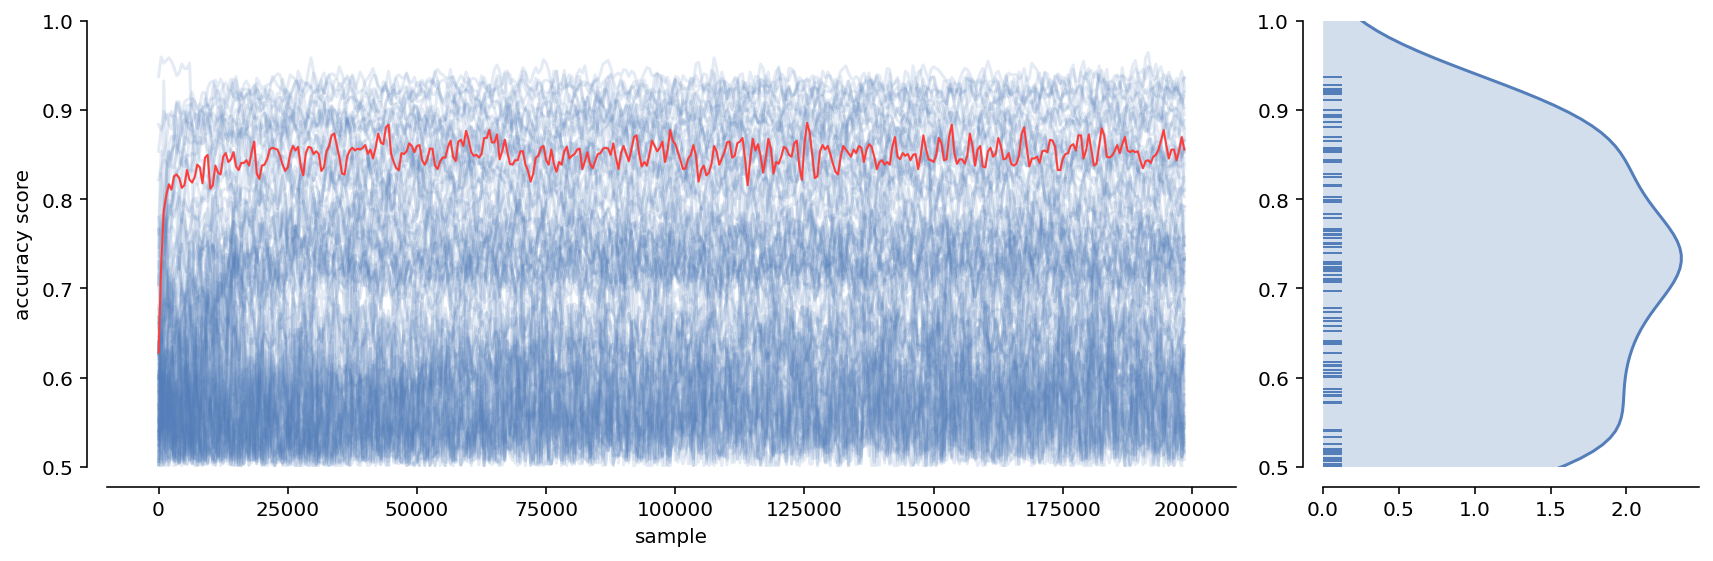

In [16]:
with FigureManager(1, 2, gridspec_kw={"width_ratios": (3, 1)}) as (
    fig,
    (ax1, ax2),
):
    for crt_rolling in two_ar3.rolling_score_biowta:
        ax1.plot(*crt_rolling, c="C0", alpha=0.15)

    idx = np.argmin(np.abs(two_ar3.result_biowta[1].trial_scores - 0.85))
    ax1.plot(*two_ar3.rolling_score_biowta[idx], c="C1", lw=1)
    
    ax1.set_ylim(0.5, 1.0)
    
    ax1.set_xlabel("sample")
    ax1.set_ylabel("accuracy score")

    sns.kdeplot(
        two_ar3.result_biowta[1].trial_scores, vertical=True, shade=True, ax=ax2
    )
    sns.rugplot(two_ar3.result_biowta[1].trial_scores, axis="y", ax=ax2)
    ax2.set_ylim(0.5, 1.0)

fig.savefig(os.path.join(fig_path, "rolling_accuracy_2x_ar3_100trials.png"), dpi=300)

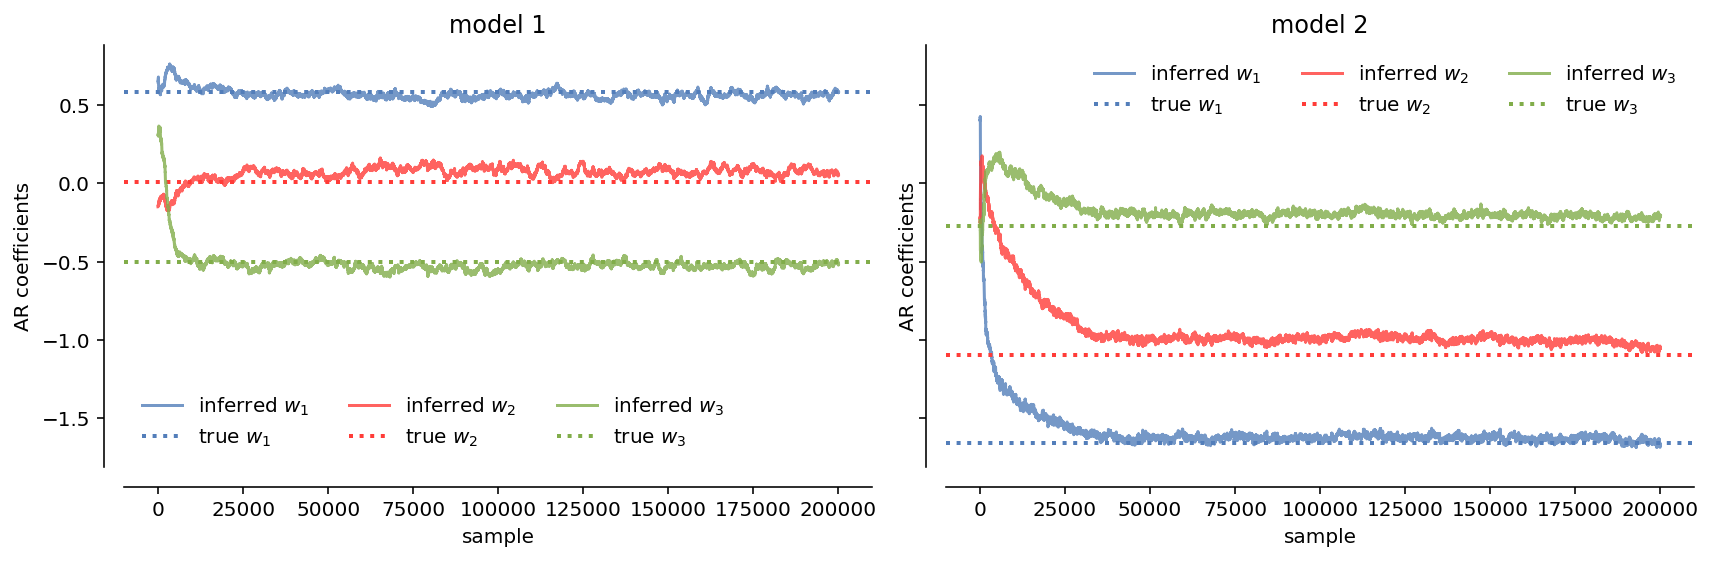

In [17]:
with FigureManager(1, two_ar3.n_models, sharey=True) as (fig, axs):
    crt_weights = two_ar3.result_biowta[1].history[idx].weights_
    for i, ax in enumerate(axs):
        crt_true = two_ar3.dataset.armas[idx][i].a
        for k in range(len(crt_true)):
            ax.plot(
                crt_weights[:, i, k], f"C{k}", alpha=0.80, label=f"inferred $w_{k + 1}$"
            )
            ax.axhline(crt_true[k], c=f"C{k}", ls=":", lw=2, label=f"true $w_{k + 1}$")

        ax.set_xlabel("sample")
        ax.set_ylabel("AR coefficients")

        ax.legend(ncol=3, frameon=False)
        ax.set_title(f"model {i + 1}")

fig.savefig(
    os.path.join(fig_path, "example_2x_ar3_model_learning.png"),
    transparent=True,
    dpi=300,
)

Accuracy score in this interval: 0.88.


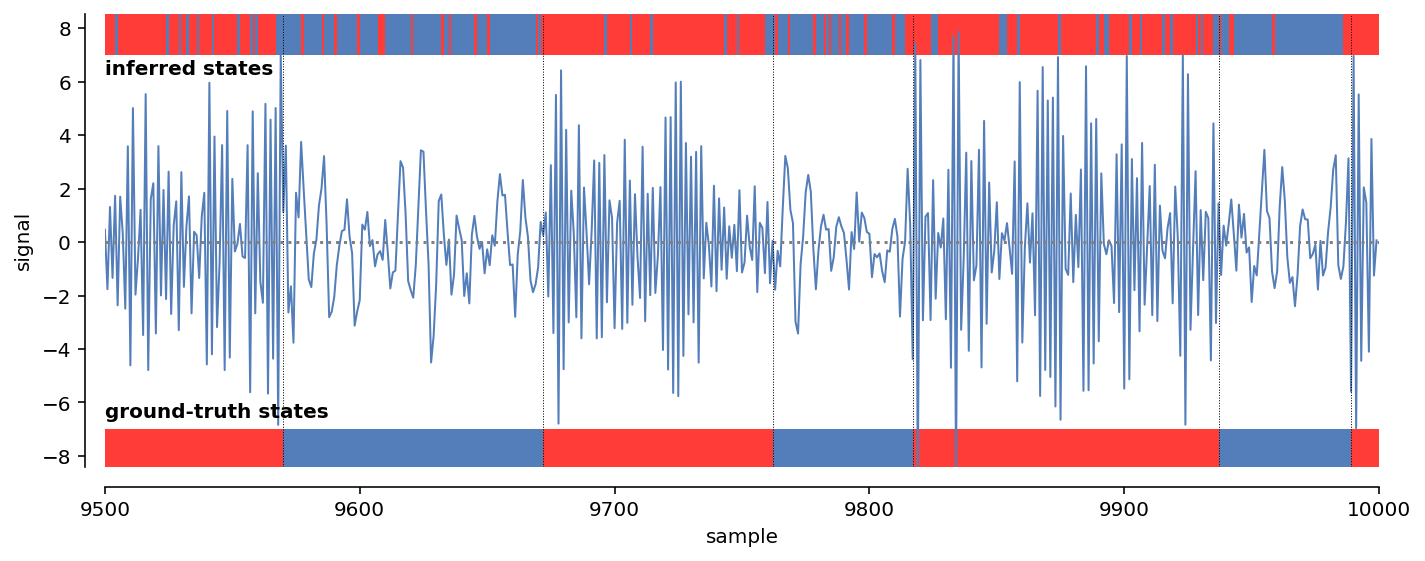

In [18]:
with FigureManager(figsize=(10, 4)) as (fig, ax):
    crt_dataset = two_ar3.dataset[idx]
    crt_n = len(crt_dataset.y)
    #  crt_range = slice(crt_n - 500, crt_n)
    crt_range = slice(9500, 10000)
    ax.plot(
        np.arange(crt_range.start, crt_range.stop),
        two_ar3.dataset[idx].y[crt_range],
        lw=1.0,
    )
    ax.axhline(0, c="gray", ls=":")
    ax.set_xlim(crt_range.start, crt_range.stop)
    ax.set_ylim(-7, 7)

    ax.set_xlabel("sample")
    ax.set_ylabel("signal")

    show_latent(crt_dataset.usage_seq, bar_location="bottom")

    crt_history = two_ar3.result_biowta[1].history[idx]
    show_latent(np.argmax(crt_history.r, axis=1), show_vlines=False)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

crt_mean = np.mean(
    crt_dataset.usage_seq[
        crt_range.start + two_ar3.n_features : crt_range.stop + two_ar3.n_features
    ]
    == np.argmax(crt_history.r, axis=1)[crt_range]
)
print(f"Accuracy score in this interval: {crt_mean:.2f}.")

fig.savefig(os.path.join(fig_path, "example_2x_ar3_short.pdf"))

Accuracy score in this interval: 0.88.


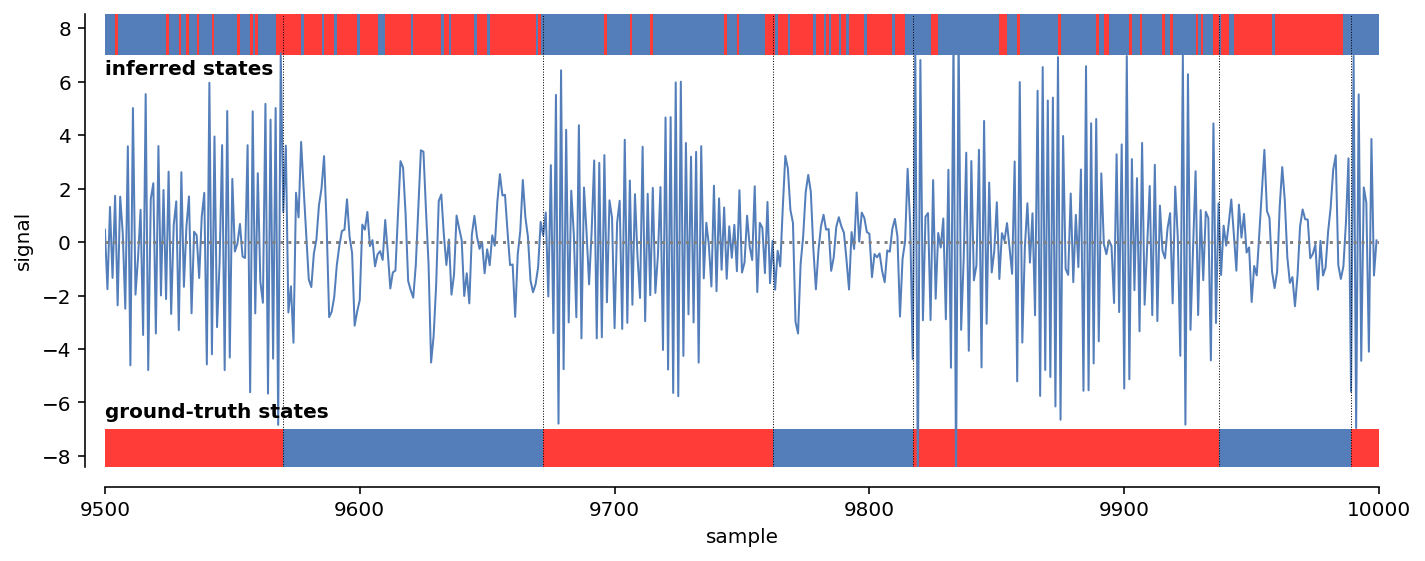

In [19]:
with FigureManager(figsize=(10, 4)) as (fig, ax):
    crt_dataset = two_ar3.dataset[idx]
    crt_n = len(crt_dataset.y)
    #  crt_range = slice(crt_n - 500, crt_n)
    crt_range = slice(9500, 10000)
    ax.plot(
        np.arange(crt_range.start, crt_range.stop),
        two_ar3.dataset[idx].y[crt_range],
        lw=1.0,
    )
    ax.axhline(0, c="gray", ls=":")
    ax.set_xlim(crt_range.start, crt_range.stop)
    ax.set_ylim(-7, 7)

    ax.set_xlabel("sample")
    ax.set_ylabel("signal")

    show_latent(crt_dataset.usage_seq, bar_location="bottom")

    crt_history = two_ar3.result_biowta[1].history[idx]
    show_latent(1 - np.argmax(crt_history.r, axis=1), show_vlines=False)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

crt_mean = np.mean(
    crt_dataset.usage_seq[
        crt_range.start + two_ar3.n_features : crt_range.stop + two_ar3.n_features
    ]
    == np.argmax(crt_history.r, axis=1)[crt_range]
)
print(f"Accuracy score in this interval: {crt_mean:.2f}.")

fig.savefig(os.path.join(fig_path, "example_2x_ar3_short_flipped.pdf"))

Attempt to predict segmentation accuracy.

In [20]:
two_ar3.diff_arma = [
    np.linalg.norm(crt_armas[0].a - crt_armas[1].a)
    for crt_armas in two_ar3.dataset.armas
]
two_ar3.predicted_score = [
    predict_accuracy(crt_armas, crt_sig)
    for crt_armas, crt_sig in zip(tqdm(two_ar3.dataset.armas), two_ar3.dataset)
]

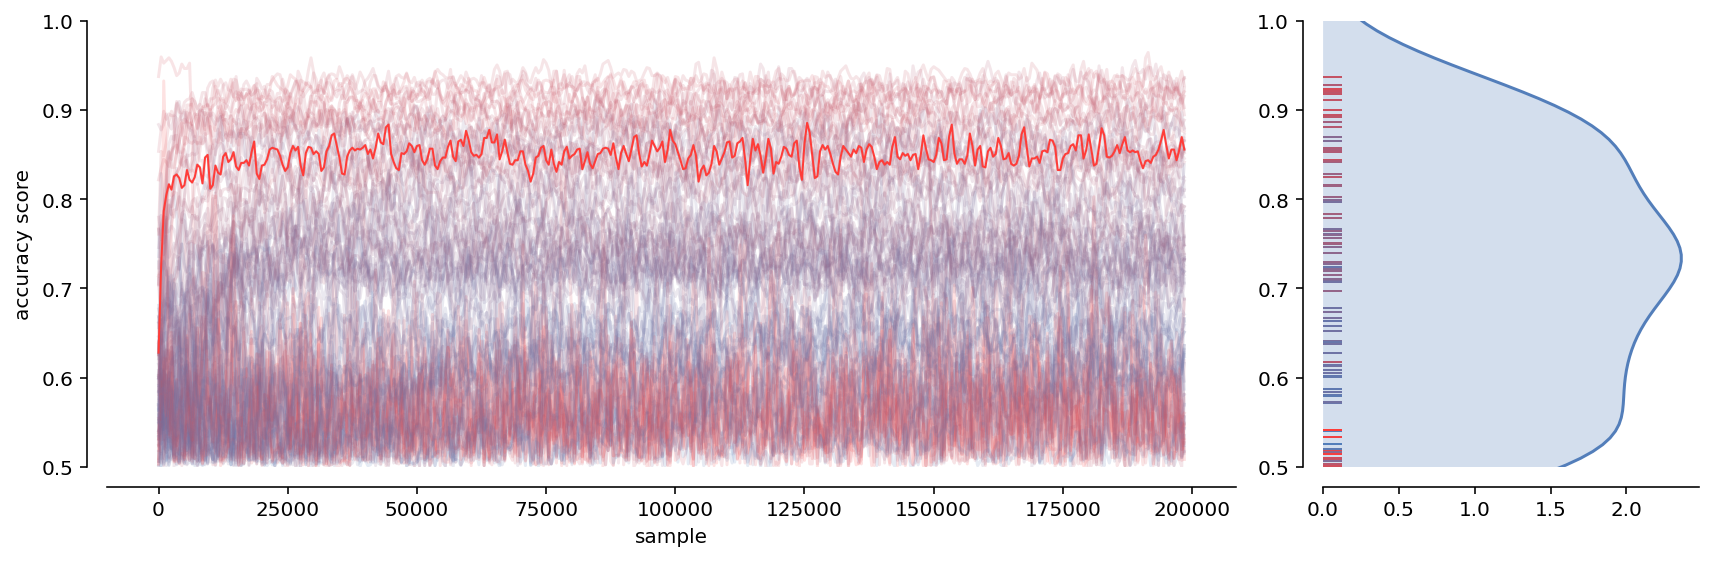

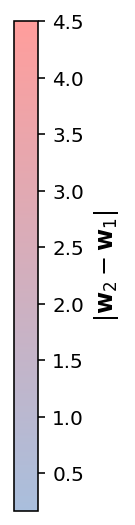

In [21]:
with FigureManager(1, 2, gridspec_kw={"width_ratios": (3, 1)}) as (
    fig,
    (ax1, ax2),
):
    crt_cmap = make_gradient_cmap("C0_to_C1", "C0", "C1")
    crt_min = np.min(two_ar3.diff_arma)
    crt_max = np.max(two_ar3.diff_arma)
    crt_range = crt_max - crt_min
    for i, crt_rolling in enumerate(two_ar3.rolling_score_biowta):
        crt_score = two_ar3.diff_arma[i]
        ax1.plot(
            *crt_rolling, c=crt_cmap((crt_score - crt_min) / crt_range), alpha=0.15
        )

    ax1.plot(*two_ar3.rolling_score_biowta[idx], c="C1", lw=1)

    ax1.set_ylim(0.5, 1.0)
    ax1.set_xlabel("sample")
    ax1.set_ylabel("accuracy score")

    sns.kdeplot(
        two_ar3.result_biowta[1].trial_scores, vertical=True, shade=True, ax=ax2
    )
    sns.rugplot(
        two_ar3.result_biowta[1].trial_scores,
        axis="y",
        colors=crt_cmap((two_ar3.diff_arma - crt_min) / crt_range),
        ax=ax2,
    )
    ax2.set_ylim(0.5, 1.0)

fig.savefig(
    os.path.join(fig_path, "rolling_accuracy_2x_ar3_100trials_color_by_armadiff.png"),
    dpi=300,
)

with FigureManager(figsize=(1.75, 3.75)) as (fig, ax):
    divider = axes_grid1.make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="25%", pad=0.05)
    crt_alpha = 0.5
    crt_rgb1 = np.asarray(mpl.colors.to_rgb("C0")) * crt_alpha + (1 - crt_alpha)
    crt_rgb2 = np.asarray(mpl.colors.to_rgb("C1")) * crt_alpha + (1 - crt_alpha)
    crt_cmap_light = make_gradient_cmap("C0_to_C1_light", crt_rgb1, crt_rgb2)
    cbar = mpl.colorbar.ColorbarBase(
        ax_cb,
        cmap=crt_cmap_light,
        orientation="vertical",
        norm=mpl.colors.Normalize(vmin=crt_min, vmax=crt_max),
    )
    cbar.set_label("$|{\\bf w}_2 - {\\bf w}_1|$", fontsize=12)
    fig.add_axes(ax_cb)

    ax.set_visible(False)

fig.savefig(
    os.path.join(fig_path, "rolling_accuracy_2x_ar3_100trials_armadiff_colorbar.png"),
    transparent=True,
    dpi=300,
)

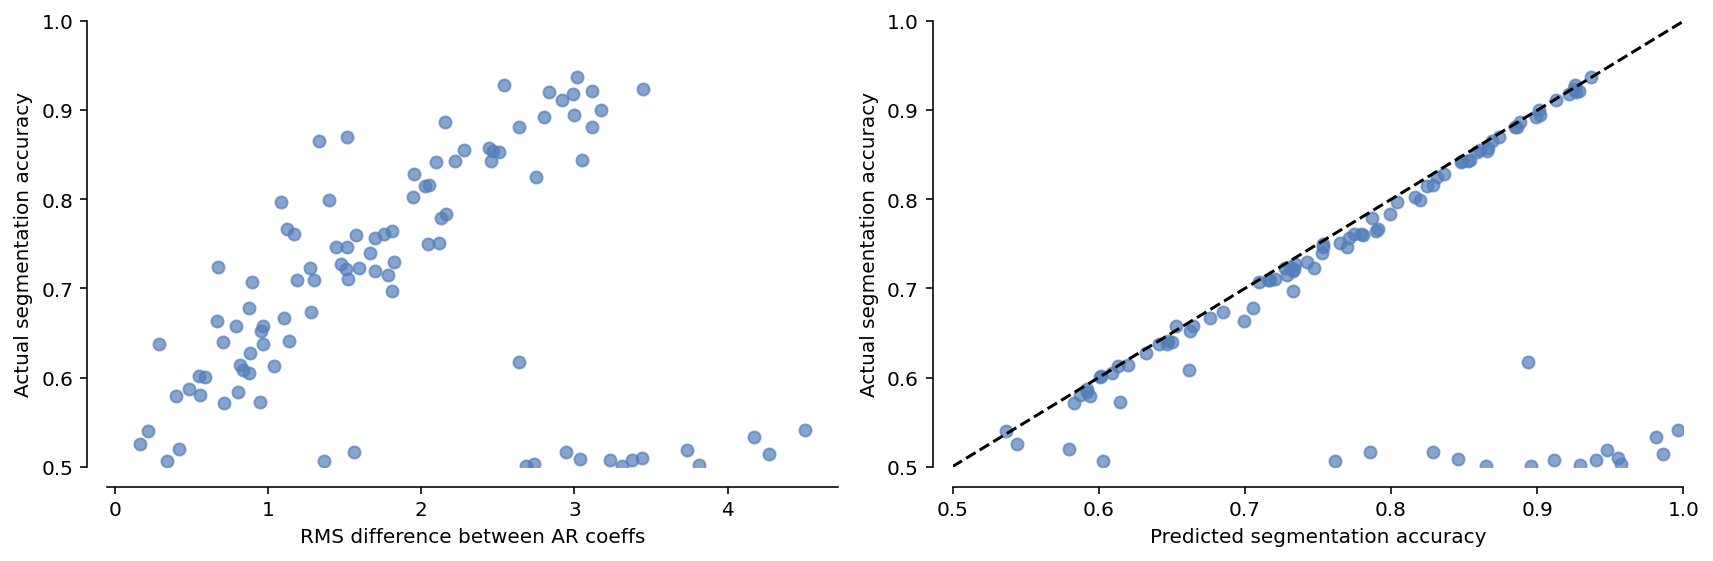

In [22]:
with FigureManager(1, 2) as (fig, (ax1, ax2)):
    ax1.scatter(two_ar3.diff_arma, two_ar3.result_biowta[1].trial_scores, alpha=0.7)

    ax1.set_ylim(0.5, 1.0)

    ax1.set_xlabel("RMS difference between AR coeffs")
    ax1.set_ylabel("Actual segmentation accuracy")

    ax2.scatter(
        two_ar3.predicted_score, two_ar3.result_biowta[1].trial_scores, alpha=0.7
    )
    ax2.plot([0.5, 1.0], [0.5, 1.0], "k--")

    ax2.set_xlim(0.5, 1.0)
    ax2.set_ylim(0.5, 1.0)

    ax2.set_xlabel("Predicted segmentation accuracy")
    ax2.set_ylabel("Actual segmentation accuracy")

fig.savefig(os.path.join(fig_path, "example_predicting_accuracy_score.pdf"))

#### Diagnose some failed runs

In [23]:
(
    (np.asarray(two_ar3.predicted_score) > 0.75)
    & (two_ar3.result_biowta[1].trial_scores < 0.6)
).nonzero()[0]

array([ 0, 16, 18, 24, 28, 36, 38, 39, 52, 54, 60, 67, 82, 90, 92])

Accuracy score in this interval: 0.62.


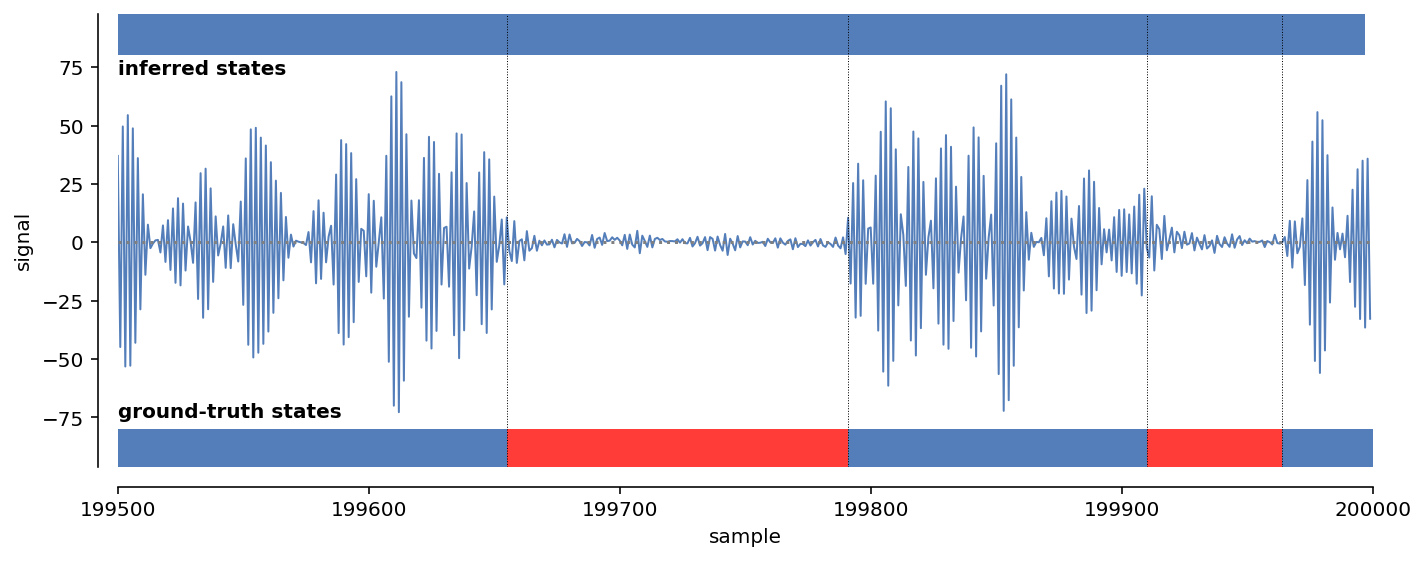

In [24]:
with FigureManager(figsize=(10, 4)) as (fig, ax):
    crt_idx = 0
    crt_dataset = two_ar3.dataset[crt_idx]
    crt_n = len(crt_dataset.y)
    crt_range = slice(crt_n - 500, crt_n)
    ax.plot(
        np.arange(crt_range.start, crt_range.stop),
        crt_dataset.y[crt_range],
        lw=1.0,
    )
    ax.axhline(0, c="gray", ls=":")
    ax.set_xlim(crt_range.start, crt_range.stop)

    ax.set_xlabel("sample")
    ax.set_ylabel("signal")

    show_latent(crt_dataset.usage_seq, bar_location="bottom")

    crt_history = two_ar3.result_biowta[1].history[crt_idx]
    show_latent(np.argmax(crt_history.r, axis=1), show_vlines=False)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

crt_mean = np.mean(
    crt_dataset.usage_seq[
        crt_range.start + two_ar3.n_features : crt_range.stop + two_ar3.n_features
    ]
    == np.argmax(crt_history.r, axis=1)[crt_range]
)
print(f"Accuracy score in this interval: {crt_mean:.2f}.")

In [25]:
two_ar3.dataset.armas[crt_idx]

[Arma(a=array([-2.63852741, -2.38270964, -0.72760411]), b=array([], dtype=float64), bias=0, default_source=None),
 Arma(a=array([-0.4666004 ,  0.37290782,  0.77077278]), b=array([], dtype=float64), bias=0, default_source=None)]

In [26]:
[[np.linalg.norm(_) for _ in two_ar3.dataset.armas[crt_idx][__].calculate_poles()] for __ in range(two_ar3.n_models)]

[[0.9670464181228928, 0.9670464181228928, 0.778037448494408],
 [0.8998078596671719, 0.9255252974817826, 0.9255252974817826]]

### Plots for autocorrelation-based results

Note that the autocorrelation-based results automatically assume non-trivial streaks.

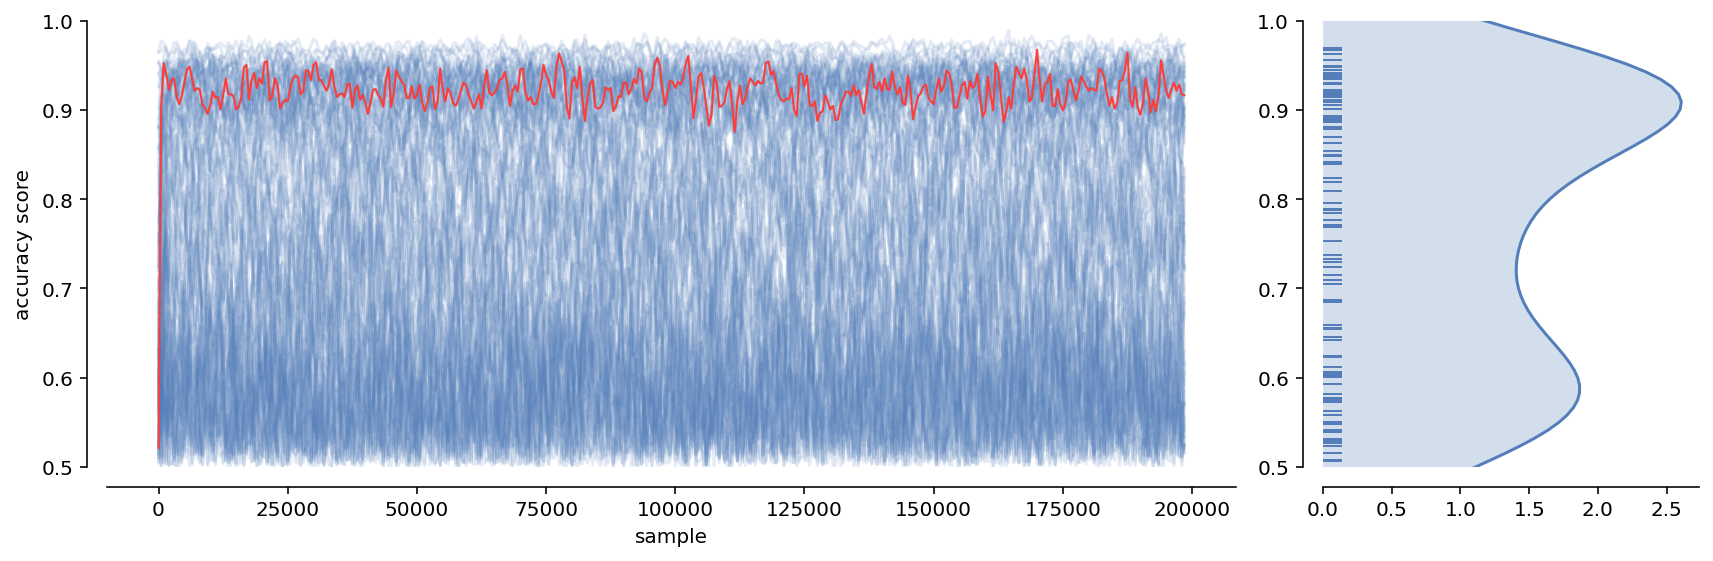

In [27]:
with FigureManager(1, 2, gridspec_kw={"width_ratios": (3, 1)}) as (
    fig,
    (ax1, ax2),
):
    for crt_rolling in two_ar3.rolling_score_xcorr:
        ax1.plot(*crt_rolling, c="C0", alpha=0.15)

    # idx = np.argmin(np.abs(two_ar3.result_xcorr[1].trial_scores - 0.85))
    ax1.plot(*two_ar3.rolling_score_xcorr[idx], c="C1", lw=1)
    
    ax1.set_ylim(0.5, 1.0)
    
    ax1.set_xlabel("sample")
    ax1.set_ylabel("accuracy score")

    sns.kdeplot(
        two_ar3.result_xcorr[1].trial_scores, vertical=True, shade=True, ax=ax2
    )
    sns.rugplot(two_ar3.result_xcorr[1].trial_scores, axis="y", ax=ax2)
    ax2.set_ylim(0.5, 1.0)

fig.savefig(os.path.join(fig_path, "rolling_accuracy_2x_ar3_100trials_xcorr.png"), dpi=300)

Accuracy score in this interval: 0.91.


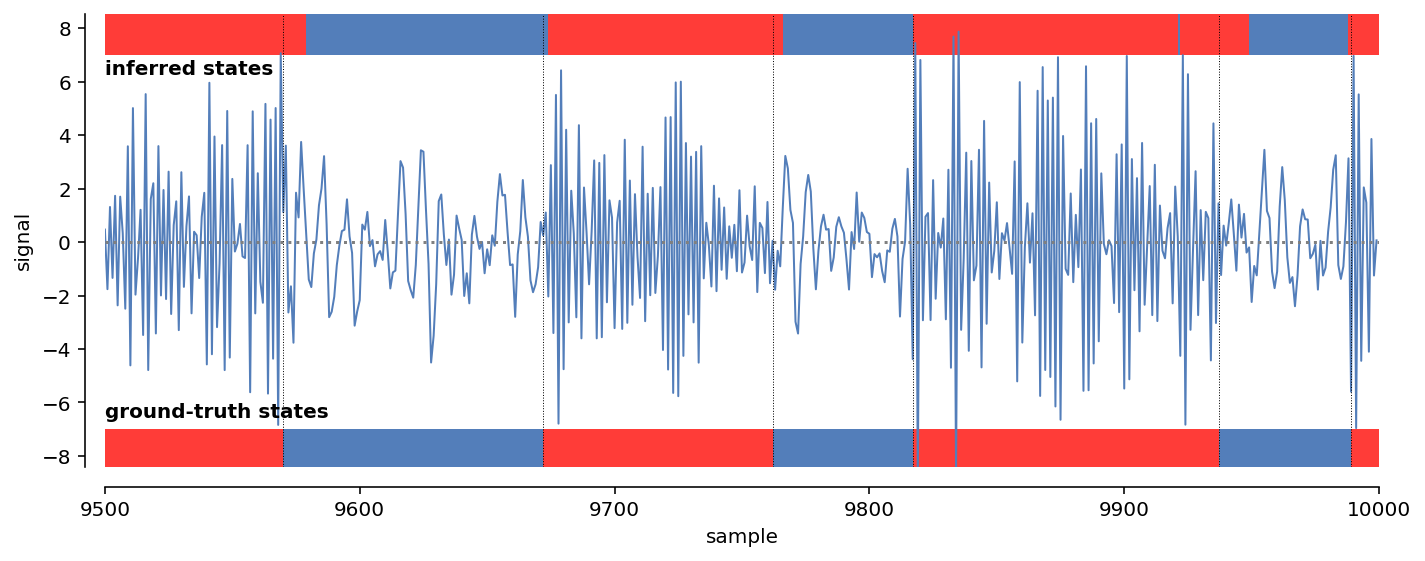

In [28]:
with FigureManager(figsize=(10, 4)) as (fig, ax):
    crt_dataset = two_ar3.dataset[idx]
    crt_n = len(crt_dataset.y)
    #  crt_range = slice(crt_n - 500, crt_n)
    crt_range = slice(9500, 10000)
    ax.plot(
        np.arange(crt_range.start, crt_range.stop),
        two_ar3.dataset[idx].y[crt_range],
        lw=1.0,
    )
    ax.axhline(0, c="gray", ls=":")
    ax.set_xlim(crt_range.start, crt_range.stop)
    ax.set_ylim(-7, 7)

    ax.set_xlabel("sample")
    ax.set_ylabel("signal")

    show_latent(crt_dataset.usage_seq, bar_location="bottom")

    crt_history = two_ar3.result_xcorr[1].history[idx]
    show_latent(np.argmax(crt_history.r, axis=1), show_vlines=False)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

crt_mean = np.mean(
    crt_dataset.usage_seq[
        crt_range.start + two_ar3.n_features : crt_range.stop + two_ar3.n_features
    ]
    == np.argmax(crt_history.r, axis=1)[crt_range]
)
print(f"Accuracy score in this interval: {crt_mean:.2f}.")

fig.savefig(os.path.join(fig_path, "example_2x_ar3_short_xcorr.pdf"))

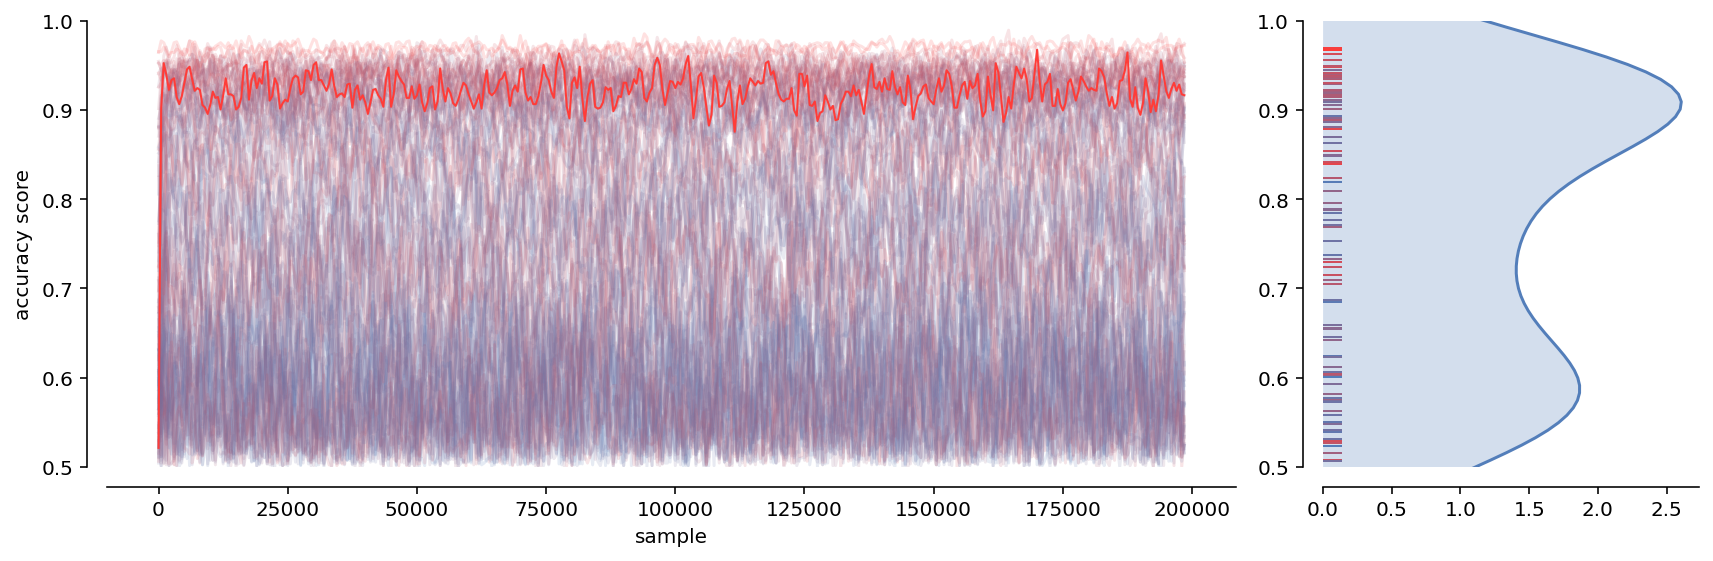

In [29]:
with FigureManager(1, 2, gridspec_kw={"width_ratios": (3, 1)}) as (
    fig,
    (ax1, ax2),
):
    crt_cmap = make_gradient_cmap("C0_to_C1", "C0", "C1")
    crt_min = np.min(two_ar3.diff_arma)
    crt_max = np.max(two_ar3.diff_arma)
    crt_range = crt_max - crt_min
    for i, crt_rolling in enumerate(two_ar3.rolling_score_xcorr):
        crt_score = two_ar3.diff_arma[i]
        ax1.plot(
            *crt_rolling, c=crt_cmap((crt_score - crt_min) / crt_range), alpha=0.15
        )

    ax1.plot(*two_ar3.rolling_score_xcorr[idx], c="C1", lw=1)

    ax1.set_ylim(0.5, 1.0)
    ax1.set_xlabel("sample")
    ax1.set_ylabel("accuracy score")

    sns.kdeplot(
        two_ar3.result_xcorr[1].trial_scores, vertical=True, shade=True, ax=ax2
    )
    sns.rugplot(
        two_ar3.result_xcorr[1].trial_scores,
        axis="y",
        colors=crt_cmap((two_ar3.diff_arma - crt_min) / crt_range),
        ax=ax2,
    )
    ax2.set_ylim(0.5, 1.0)

fig.savefig(
    os.path.join(fig_path, "rolling_accuracy_2x_ar3_100trials_xcorr_color_by_armadiff.png"),
    dpi=300,
)

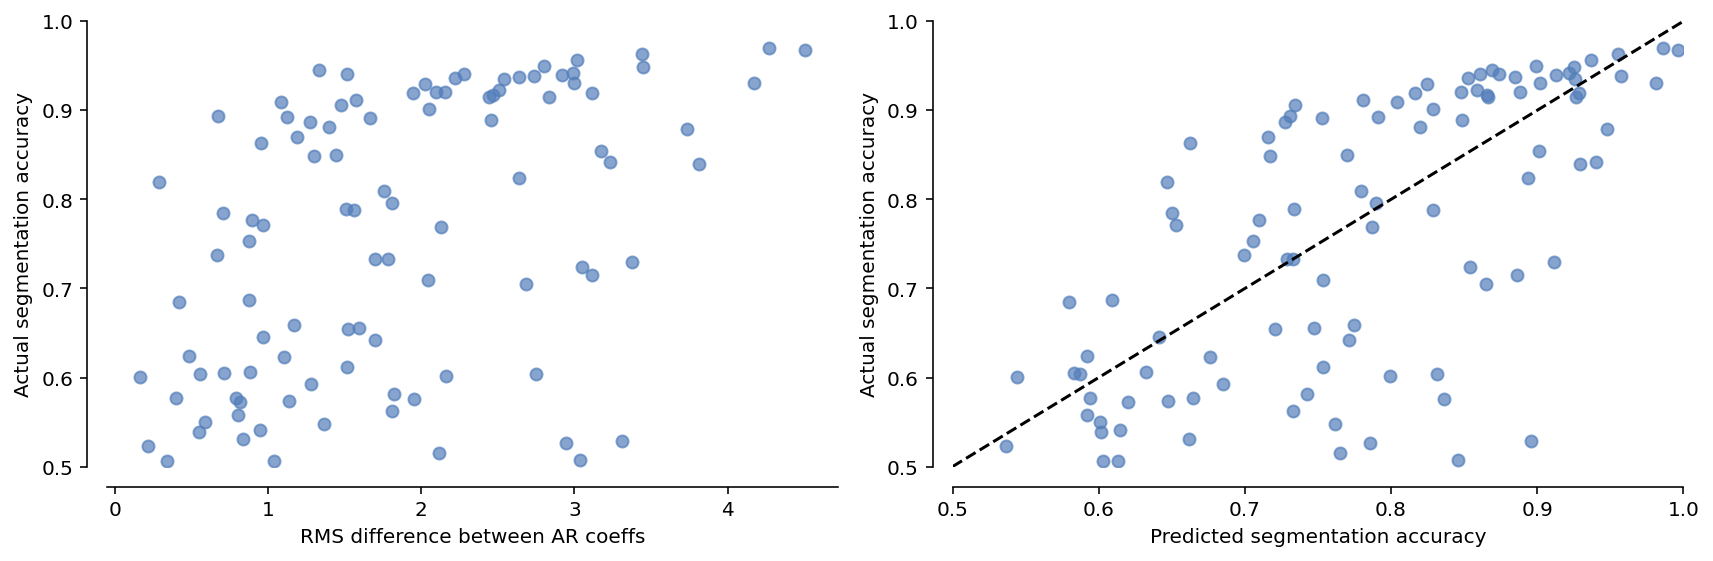

In [30]:
with FigureManager(1, 2) as (fig, (ax1, ax2)):
    ax1.scatter(two_ar3.diff_arma, two_ar3.result_xcorr[1].trial_scores, alpha=0.7)

    ax1.set_ylim(0.5, 1.0)

    ax1.set_xlabel("RMS difference between AR coeffs")
    ax1.set_ylabel("Actual segmentation accuracy")

    ax2.scatter(
        two_ar3.predicted_score, two_ar3.result_xcorr[1].trial_scores, alpha=0.7
    )
    ax2.plot([0.5, 1.0], [0.5, 1.0], "k--")

    ax2.set_xlim(0.5, 1.0)
    ax2.set_ylim(0.5, 1.0)

    ax2.set_xlabel("Predicted segmentation accuracy")
    ax2.set_ylabel("Actual segmentation accuracy")

fig.savefig(os.path.join(fig_path, "example_predicting_accuracy_score_xcorr.pdf"))

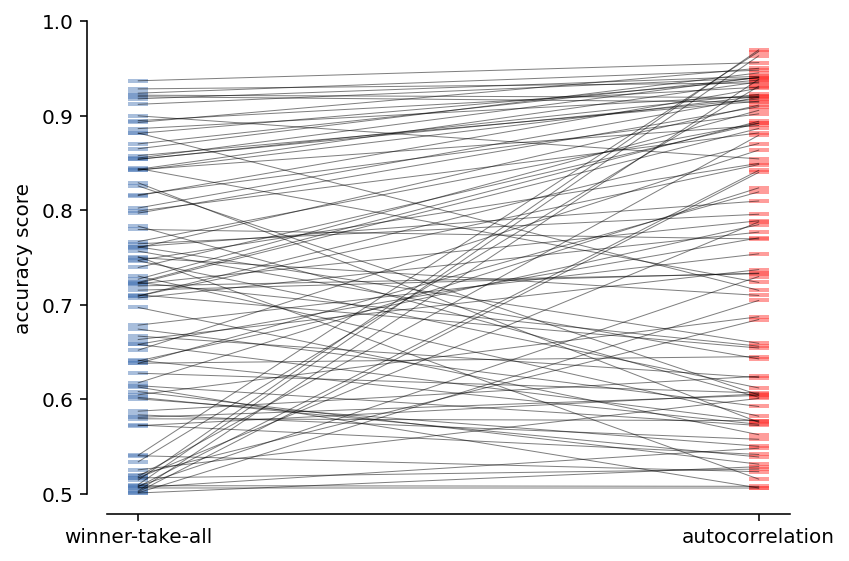

In [31]:
with FigureManager() as (fig, ax):
    crt_wta_scores = two_ar3.result_biowta[1].trial_scores
    crt_xcorr_scores = two_ar3.result_xcorr[1].trial_scores

    ax.plot(
        np.zeros(two_ar3.n_signals),
        crt_wta_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C0",
        alpha=0.5,
    )
    ax.plot(
        np.ones(two_ar3.n_signals),
        crt_xcorr_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C1",
        alpha=0.5,
    )
    ax.plot(
        np.row_stack((np.zeros(two_ar3.n_signals), np.ones(two_ar3.n_signals))),
        np.row_stack((crt_wta_scores, crt_xcorr_scores)),
        "k-",
        lw=0.5,
        alpha=0.5,
    )
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["winner-take-all", "autocorrelation"])

    ax.set_ylim(0.5, 1)

    ax.set_ylabel("accuracy score")

fig.savefig(os.path.join(fig_path, "naive_biowta_vs_xcorr.pdf"))

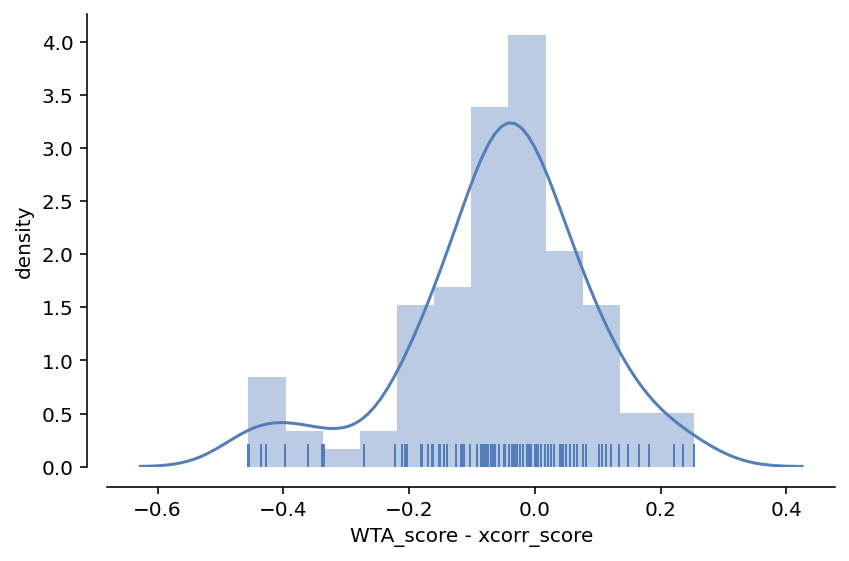

In [32]:
with FigureManager() as (_, ax):
    sns.distplot(
        two_ar3.result_biowta[1].trial_scores - two_ar3.result_xcorr[1].trial_scores,
        rug=True,
        ax=ax,
    )
    ax.set_xlabel("WTA_score - xcorr_score")
    ax.set_ylabel("density")

In [33]:
(
    (np.asarray(two_ar3.predicted_score) > 0.75)
    & (two_ar3.result_xcorr[1].trial_scores < 0.6)
).nonzero()[0]

array([38, 54, 64, 90, 91, 92])

Accuracy score in this interval: 0.36.


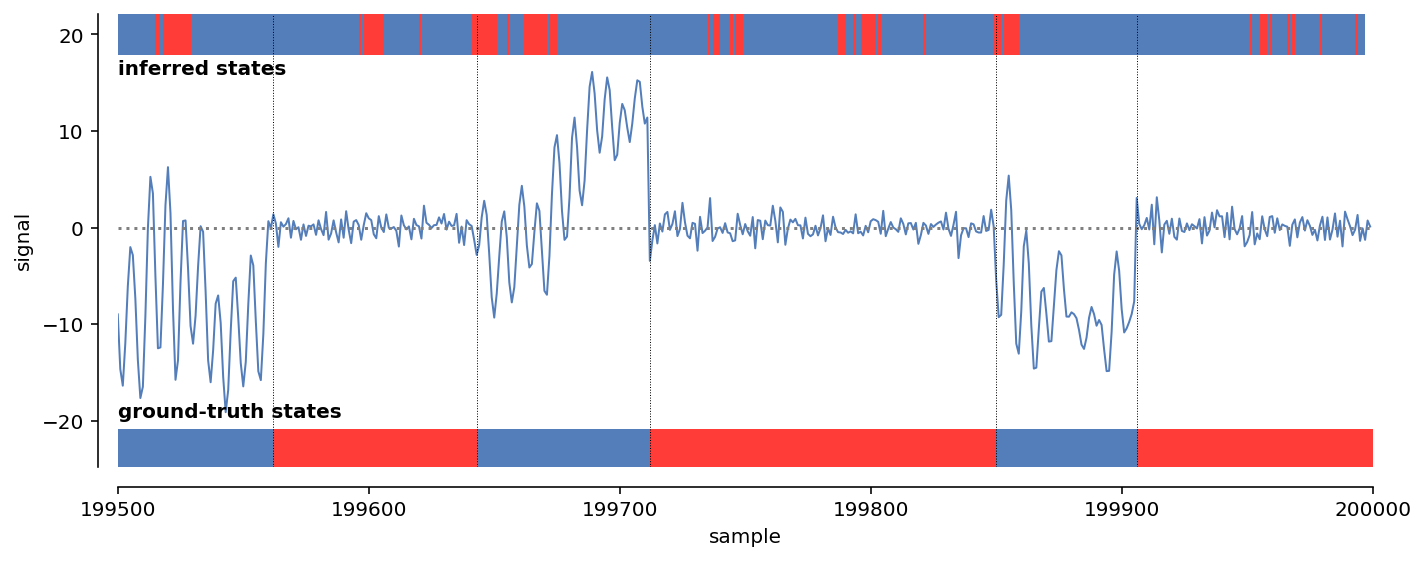

In [34]:
with FigureManager(figsize=(10, 4)) as (fig, ax):
    crt_idx = 38
    crt_dataset = two_ar3.dataset[crt_idx]
    crt_n = len(crt_dataset.y)
    crt_range = slice(crt_n - 500, crt_n)
    ax.plot(
        np.arange(crt_range.start, crt_range.stop),
        crt_dataset.y[crt_range],
        lw=1.0,
    )
    ax.axhline(0, c="gray", ls=":")
    ax.set_xlim(crt_range.start, crt_range.stop)

    ax.set_xlabel("sample")
    ax.set_ylabel("signal")

    show_latent(crt_dataset.usage_seq, bar_location="bottom")

    crt_history = two_ar3.result_xcorr[1].history[crt_idx]
    show_latent(np.argmax(crt_history.r, axis=1), show_vlines=False)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

crt_mean = np.mean(
    crt_dataset.usage_seq[
        crt_range.start + two_ar3.n_features : crt_range.stop + two_ar3.n_features
    ]
    == np.argmax(crt_history.r, axis=1)[crt_range]
)
print(f"Accuracy score in this interval: {crt_mean:.2f}.")

In [35]:
two_ar3.dataset.armas[crt_idx]

[Arma(a=array([ 2.17919209, -2.15435055,  0.96943361]), b=array([], dtype=float64), bias=0, default_source=None),
 Arma(a=array([-0.23082174, -0.11378922, -0.02321241]), b=array([], dtype=float64), bias=0, default_source=None)]

In [36]:
[[np.linalg.norm(_) for _ in two_ar3.dataset.armas[crt_idx][__].calculate_poles()] for __ in range(two_ar3.n_models)]

[[0.9927539941968309, 0.9881849008095943, 0.9881849008095943],
 [0.33123380172539824, 0.33123380172539824, 0.21156845572652933]]

## Run `BioWTA` with non-trivial `trans_mat`

In [37]:
t0 = time.time()
two_ar3.result_biowta_streak = hyper_score_ar(
    BioWTARegressor,
    two_ar3.dataset,
    two_ar3.metric,
    n_models=two_ar3.n_models,
    n_features=two_ar3.n_features,
    rate=two_ar3.rate_biowta,
    trans_mat=1 - 1 / two_ar3.streak_biowta,
    progress=tqdm,
    monitor=["r", "weights_", "prediction_"],
)
t1 = time.time()
print(
    f"Median accuracy score BioWTA with streak: {two_ar3.result_biowta_streak[0]:.2}. "
    f"(Took {t1 - t0:.2f} seconds.)"
)


Median accuracy score BioWTA with streak: 0.8. (Took 53.58 seconds.)


In [38]:
two_ar3.rolling_score_biowta_streak = []
for i in tqdm(range(two_ar3.n_signals)):
    crt_dataset = two_ar3.dataset[i]

    crt_r_biowta = two_ar3.result_biowta_streak[1].history[i].r
    crt_inferred_biowta = np.argmax(crt_r_biowta, axis=1)

    crt_loc_biowta, crt_sliding_score_biowta = calculate_sliding_score(
        two_ar3.metric, crt_dataset.usage_seq, crt_inferred_biowta
    )
    two_ar3.rolling_score_biowta_streak.append(
        (crt_loc_biowta, crt_sliding_score_biowta)
    )

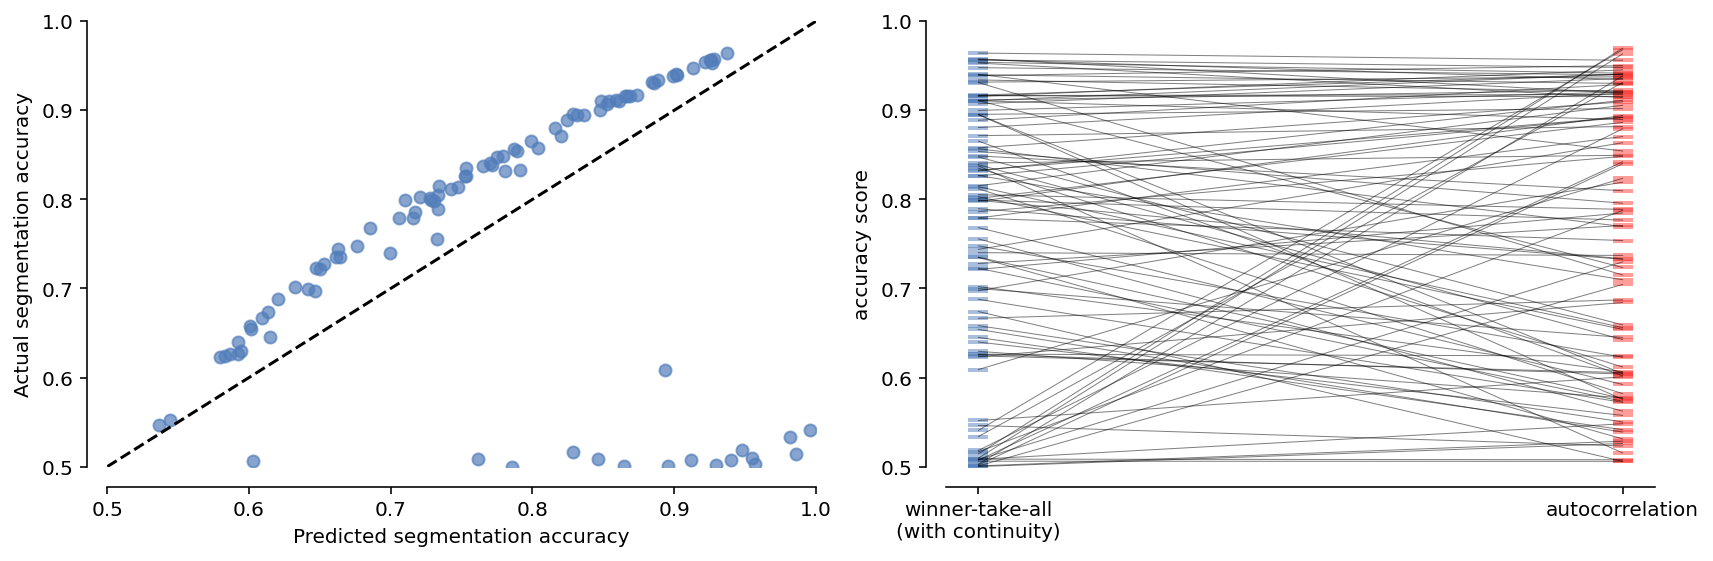

In [39]:
with FigureManager(1, 2) as (fig, (ax1, ax2)):
    ax1.scatter(
        two_ar3.predicted_score, two_ar3.result_biowta_streak[1].trial_scores, alpha=0.7
    )
    ax1.plot([0.5, 1.0], [0.5, 1.0], "k--")

    ax1.set_xlim(0.5, 1.0)
    ax1.set_ylim(0.5, 1.0)

    ax1.set_xlabel("Predicted segmentation accuracy")
    ax1.set_ylabel("Actual segmentation accuracy")

    crt_wta_scores = two_ar3.result_biowta_streak[1].trial_scores
    crt_xcorr_scores = two_ar3.result_xcorr[1].trial_scores

    ax2.plot(
        np.zeros(two_ar3.n_signals),
        crt_wta_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C0",
        alpha=0.5,
    )
    ax2.plot(
        np.ones(two_ar3.n_signals),
        crt_xcorr_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C1",
        alpha=0.5,
    )
    ax2.plot(
        np.row_stack((np.zeros(two_ar3.n_signals), np.ones(two_ar3.n_signals))),
        np.row_stack((crt_wta_scores, crt_xcorr_scores)),
        "k-",
        lw=0.5,
        alpha=0.5,
    )
    ax2.set_xticks([0, 1])
    ax2.set_xticklabels(["winner-take-all\n(with continuity)", "autocorrelation"])

    ax2.set_ylim(0.5, 1)

    ax2.set_ylabel("accuracy score")

fig.savefig(os.path.join(fig_path, "biowta_results_with_streak.pdf"), transparent=True)

Accuracy score in this interval: 0.92.


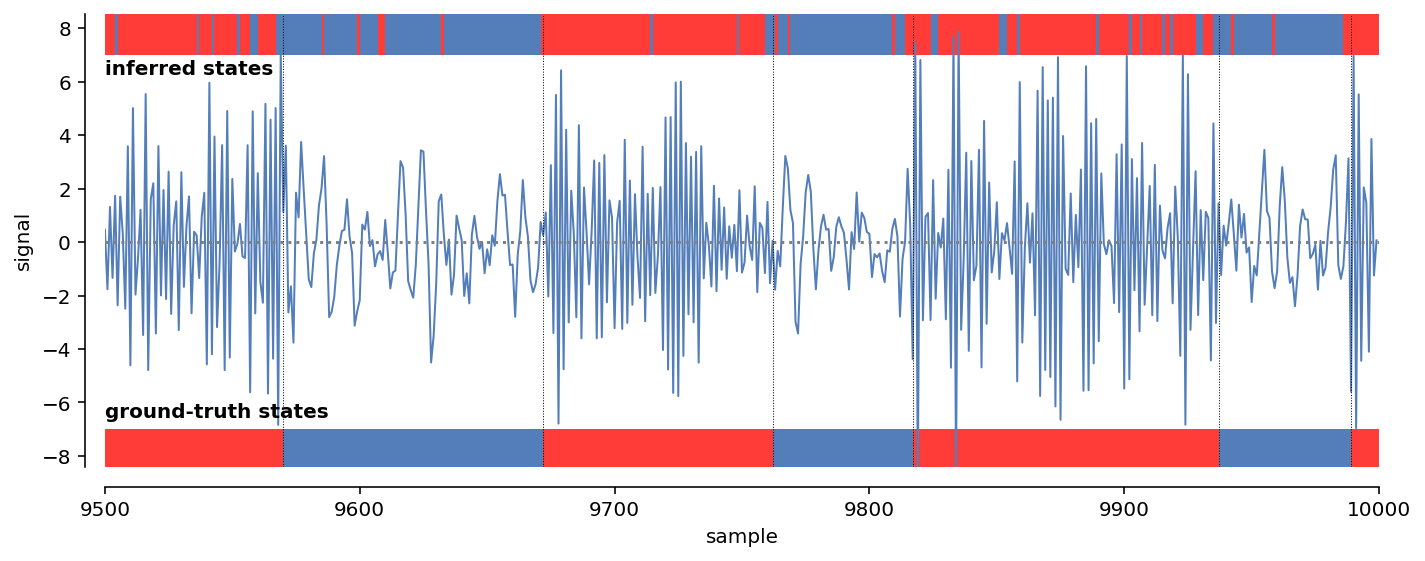

In [40]:
with FigureManager(figsize=(10, 4)) as (fig, ax):
    crt_dataset = two_ar3.dataset[idx]
    crt_n = len(crt_dataset.y)
    #  crt_range = slice(crt_n - 500, crt_n)
    crt_range = slice(9500, 10000)
    ax.plot(
        np.arange(crt_range.start, crt_range.stop),
        two_ar3.dataset[idx].y[crt_range],
        lw=1.0,
    )
    ax.axhline(0, c="gray", ls=":")
    ax.set_xlim(crt_range.start, crt_range.stop)
    ax.set_ylim(-7, 7)

    ax.set_xlabel("sample")
    ax.set_ylabel("signal")

    show_latent(crt_dataset.usage_seq, bar_location="bottom")

    crt_history = two_ar3.result_biowta_streak[1].history[idx]
    show_latent(np.argmax(crt_history.r, axis=1), show_vlines=False)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

crt_mean = np.mean(
    crt_dataset.usage_seq[
        crt_range.start + two_ar3.n_features : crt_range.stop + two_ar3.n_features
    ]
    == np.argmax(crt_history.r, axis=1)[crt_range]
)
print(f"Accuracy score in this interval: {crt_mean:.2f}.")

fig.savefig(os.path.join(fig_path, "example_2x_ar3_short_biowta_streak.pdf"))

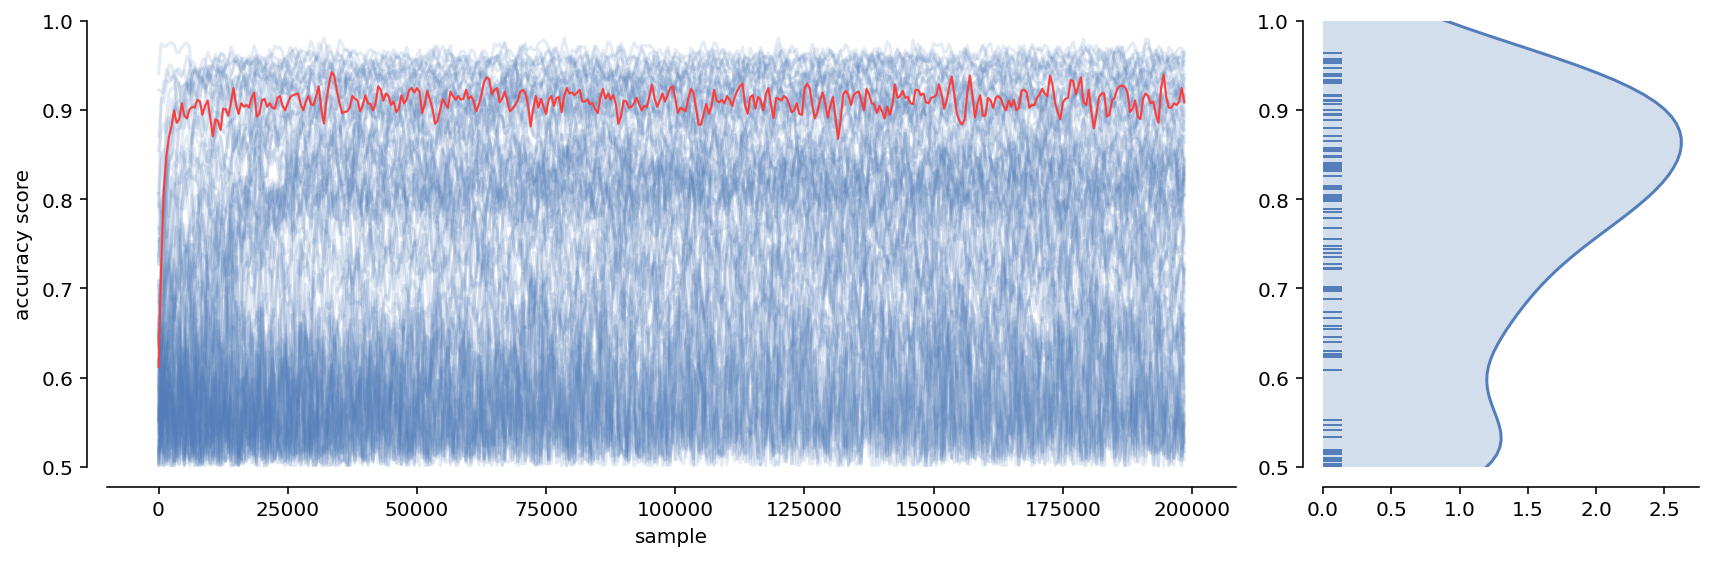

In [41]:
with FigureManager(1, 2, gridspec_kw={"width_ratios": (3, 1)}) as (
    fig,
    (ax1, ax2),
):
    for crt_rolling in two_ar3.rolling_score_biowta_streak:
        ax1.plot(*crt_rolling, c="C0", alpha=0.15)

    ax1.plot(*two_ar3.rolling_score_biowta_streak[idx], c="C1", lw=1)

    ax1.set_ylim(0.5, 1.0)

    ax1.set_xlabel("sample")
    ax1.set_ylabel("accuracy score")

    sns.kdeplot(
        two_ar3.result_biowta_streak[1].trial_scores, vertical=True, shade=True, ax=ax2
    )
    sns.rugplot(two_ar3.result_biowta_streak[1].trial_scores, axis="y", ax=ax2)
    ax2.set_ylim(0.5, 1.0)

fig.savefig(
    os.path.join(fig_path, "rolling_accuracy_2x_ar3_100trials_biowta_streak.png"),
    dpi=300,
)

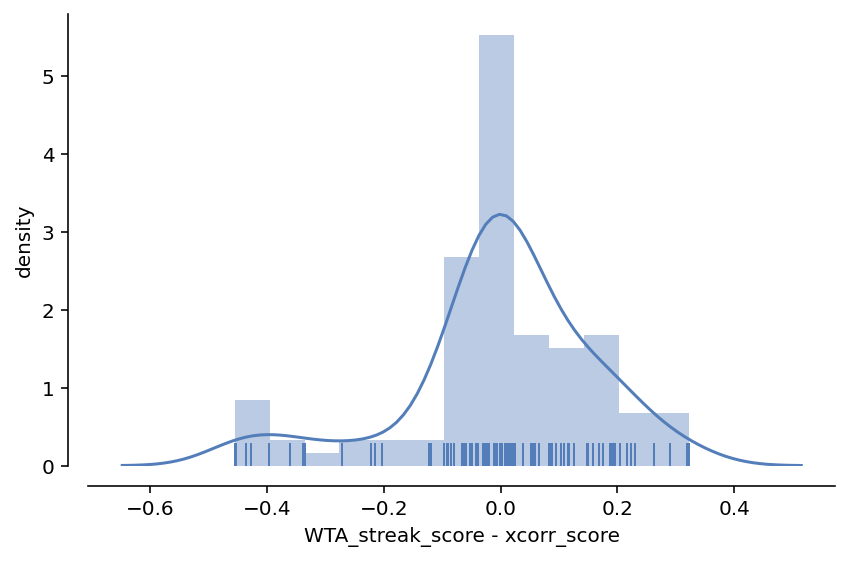

In [42]:
with FigureManager() as (_, ax):
    sns.distplot(
        two_ar3.result_biowta_streak[1].trial_scores - two_ar3.result_xcorr[1].trial_scores,
        rug=True,
        ax=ax,
    )
    ax.set_xlabel("WTA_streak_score - xcorr_score")
    ax.set_ylabel("density")

## Get cepstral results

In [43]:
t0 = time.time()
two_ar3.result_cepstral_details = SimpleNamespace(
    trial_scores=np.zeros(two_ar3.n_signals),
    regressor_seeds=np.zeros(two_ar3.n_signals, dtype=int),
    regressors=[],
    history=[SimpleNamespace() for _ in range(two_ar3.n_signals)],
)

for i, crt_signal in enumerate(tqdm(two_ar3.dataset)):
    crt_regressor = CepstralOracleRegressor(
        two_ar3.dataset.armas[i],
        two_ar3.n_features,
        cepstral_rate=two_ar3.rate_cepstral,
    )
    crt_r = fit_infer_ar(crt_regressor, crt_signal.y)
    two_ar3.result_cepstral_details.history[i].r = crt_r
    two_ar3.result_cepstral_details.regressors.append(crt_regressor)

    crt_inferred_usage = np.argmax(two_ar3.result_cepstral_details.history[i].r, axis=1)
    crt_n = int(0.2 * len(crt_inferred_usage))
    two_ar3.result_cepstral_details.trial_scores[i] = unordered_accuracy_score(
        crt_signal.usage_seq[-crt_n:], crt_inferred_usage[-crt_n:]
    )

two_ar3.result_cepstral = (
    np.median(two_ar3.result_cepstral_details.trial_scores),
    two_ar3.result_cepstral_details,
)

t1 = time.time()
print(
    f"Median accuracy score cepstral: {two_ar3.result_cepstral[0]:.2}. "
    f"(Took {t1 - t0:.2f} seconds.)"
)


Median accuracy score cepstral: 0.91. (Took 4035.13 seconds.)


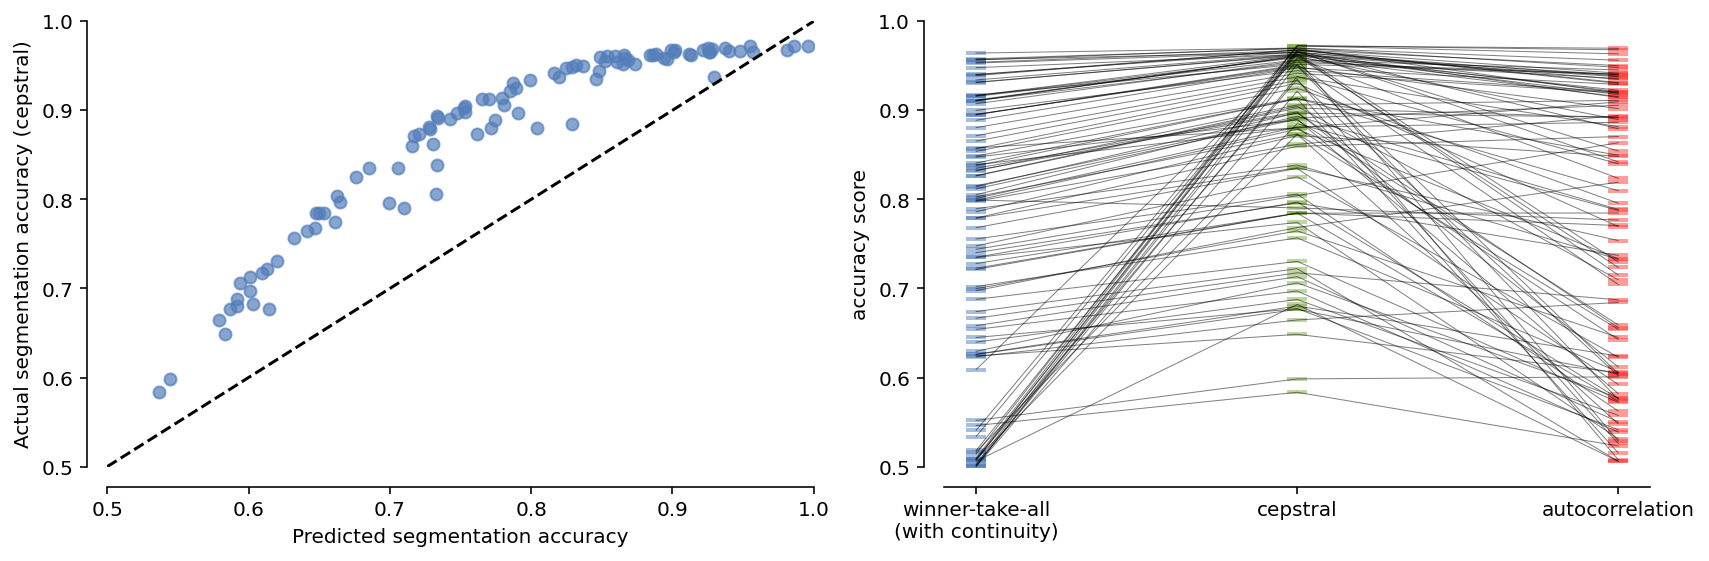

In [44]:
with FigureManager(1, 2) as (fig, (ax1, ax2)):
    ax1.scatter(
        two_ar3.predicted_score, two_ar3.result_cepstral[1].trial_scores, alpha=0.7
    )
    ax1.plot([0.5, 1.0], [0.5, 1.0], "k--")

    ax1.set_xlim(0.5, 1.0)
    ax1.set_ylim(0.5, 1.0)

    ax1.set_xlabel("Predicted segmentation accuracy")
    ax1.set_ylabel("Actual segmentation accuracy (cepstral)")

    crt_wta_scores = two_ar3.result_biowta_streak[1].trial_scores
    crt_xcorr_scores = two_ar3.result_xcorr[1].trial_scores
    crt_cepstral_scores = two_ar3.result_cepstral[1].trial_scores

    ax2.plot(
        np.zeros(two_ar3.n_signals),
        crt_wta_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C0",
        alpha=0.5,
    )
    ax2.plot(
        0.5 * np.ones(two_ar3.n_signals),
        crt_cepstral_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C2",
        alpha=0.5,
    )
    ax2.plot(
        np.ones(two_ar3.n_signals),
        crt_xcorr_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C1",
        alpha=0.5,
    )

    ax2.plot(
        np.row_stack(
            (
                np.zeros(two_ar3.n_signals),
                0.5 * np.ones(two_ar3.n_signals),
                np.ones(two_ar3.n_signals),
            )
        ),
        np.row_stack((crt_wta_scores, crt_cepstral_scores, crt_xcorr_scores)),
        "k-",
        lw=0.5,
        alpha=0.5,
    )
    ax2.set_xticks([0, 0.5, 1])
    ax2.set_xticklabels(
        ["winner-take-all\n(with continuity)", "cepstral", "autocorrelation"]
    )

    ax2.set_ylim(0.5, 1)

    ax2.set_ylabel("accuracy score")

# fig.savefig(os.path.join(fig_path, "cepstral_results_vs_xcorr_and_biowta_with_streak.pdf"), transparent=True)

## Get average-error results

In [45]:
t0 = time.time()
two_ar3.result_avg_error_details = SimpleNamespace(
    trial_scores=np.zeros(two_ar3.n_signals),
    regressor_seeds=np.zeros(two_ar3.n_signals, dtype=int),
    regressors=[],
    history=[SimpleNamespace() for _ in range(two_ar3.n_signals)],
)

for i, crt_signal in enumerate(tqdm(two_ar3.dataset)):
    crt_regressor = AverageErrorRegressor(
        two_ar3.dataset.armas[i], variance_rate=two_ar3.rate_avg_error,
    )
    crt_r = fit_infer_ar(crt_regressor, crt_signal.y)
    two_ar3.result_avg_error_details.history[i].r = crt_r
    two_ar3.result_avg_error_details.regressors.append(crt_regressor)

    crt_inferred_usage = np.argmax(
        two_ar3.result_avg_error_details.history[i].r, axis=1
    )
    crt_n = int(0.2 * len(crt_inferred_usage))
    two_ar3.result_avg_error_details.trial_scores[i] = unordered_accuracy_score(
        crt_signal.usage_seq[-crt_n:], crt_inferred_usage[-crt_n:]
    )

two_ar3.result_avg_error = (
    np.median(two_ar3.result_avg_error_details.trial_scores),
    two_ar3.result_avg_error_details,
)

t1 = time.time()
print(
    f"Median accuracy score average error: {two_ar3.result_avg_error[0]:.2}. "
    f"(Took {t1 - t0:.2f} seconds.)"
)


Median accuracy score average error: 0.93. (Took 12.54 seconds.)


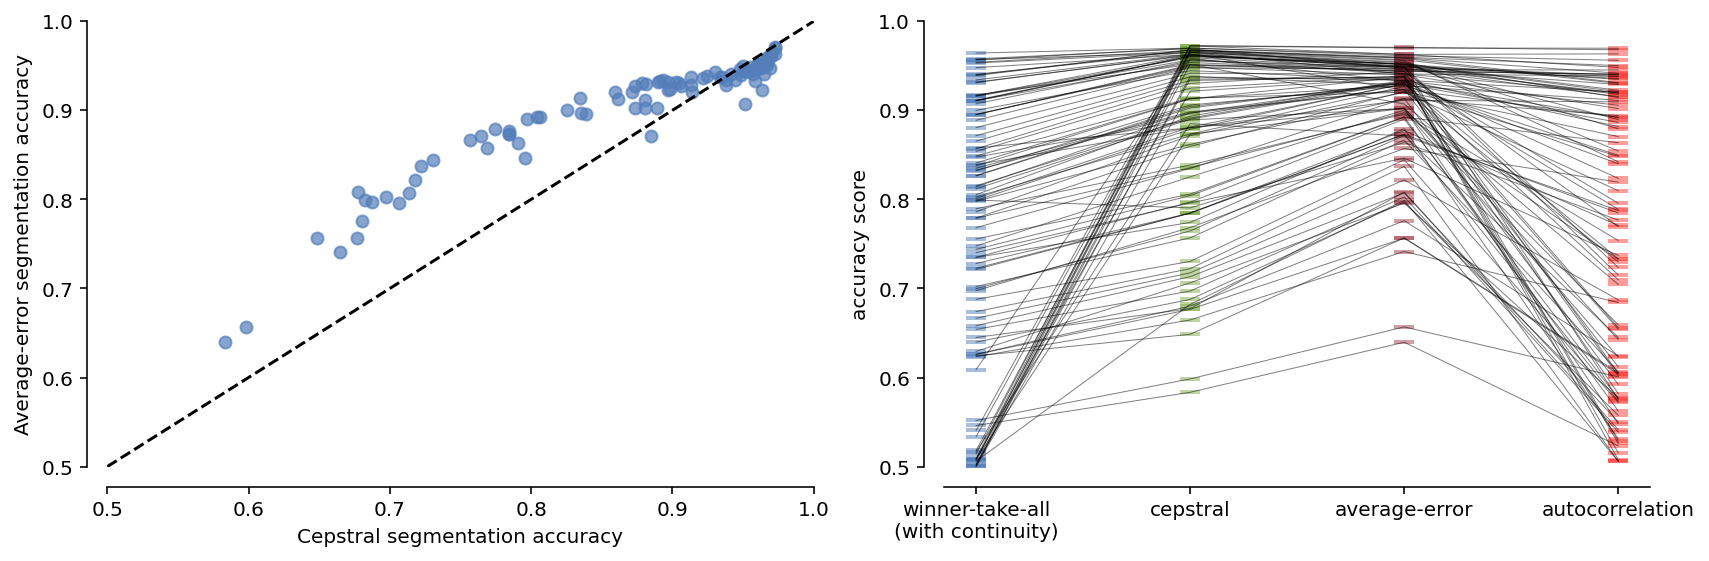

In [46]:
with FigureManager(1, 2) as (fig, (ax1, ax2)):
    ax1.scatter(
        two_ar3.result_cepstral[1].trial_scores,
        two_ar3.result_avg_error[1].trial_scores,
        alpha=0.7,
    )
    ax1.plot([0.5, 1.0], [0.5, 1.0], "k--")

    ax1.set_xlim(0.5, 1.0)
    ax1.set_ylim(0.5, 1.0)

    ax1.set_xlabel("Cepstral segmentation accuracy")
    ax1.set_ylabel("Average-error segmentation accuracy")

    crt_wta_scores = two_ar3.result_biowta_streak[1].trial_scores
    crt_xcorr_scores = two_ar3.result_xcorr[1].trial_scores
    crt_cepstral_scores = two_ar3.result_cepstral[1].trial_scores
    crt_avg_error_scores = two_ar3.result_avg_error[1].trial_scores

    ax2.plot(
        np.zeros(two_ar3.n_signals),
        crt_wta_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C0",
        alpha=0.5,
    )
    ax2.plot(
        np.ones(two_ar3.n_signals) / 3,
        crt_cepstral_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C2",
        alpha=0.5,
    )
    ax2.plot(
        2 * np.ones(two_ar3.n_signals) / 3,
        crt_avg_error_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C3",
        alpha=0.5,
    )
    ax2.plot(
        np.ones(two_ar3.n_signals),
        crt_xcorr_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C1",
        alpha=0.5,
    )

    ax2.plot(
        np.row_stack(
            (
                np.zeros(two_ar3.n_signals),
                np.ones(two_ar3.n_signals) / 3,
                2 * np.ones(two_ar3.n_signals) / 3,
                np.ones(two_ar3.n_signals),
            )
        ),
        np.row_stack(
            (
                crt_wta_scores,
                crt_cepstral_scores,
                crt_avg_error_scores,
                crt_xcorr_scores,
            )
        ),
        "k-",
        lw=0.5,
        alpha=0.5,
    )
    ax2.set_xticks(np.arange(4) / 3)
    ax2.set_xticklabels(
        [
            "winner-take-all\n(with continuity)",
            "cepstral",
            "average-error",
            "autocorrelation",
        ]
    )

    ax2.set_ylim(0.5, 1)

    ax2.set_ylabel("accuracy score")

# fig.savefig(os.path.join(fig_path, "cepstral_results_vs_xcorr_and_biowta_with_streak.pdf"), transparent=True)

## Temporal correlations explanation

In [47]:
rng = np.random.default_rng(4)

# scales chosen so the outputs of both processes have aproximately unit variance
two_ar_short = SimpleNamespace(
    arma1=Arma(
        [-0.474], [], default_source=sources.GaussianNoise(scale=0.9356, rng=rng)
    ),
    arma2=Arma(
        [0.6], [], default_source=sources.GaussianNoise(scale=0.885, rng=rng)
    ),
)
two_ar_short.armas = [two_ar_short.arma1, two_ar_short.arma2]

crt_samples1 = two_ar_short.arma1.transform(100000)
crt_samples2 = two_ar_short.arma2.transform(100000)

print("should be zero:", np.std(crt_samples1) - 1, np.std(crt_samples2) - 1)

two_ar_short.n_samples = 500
two_ar_short.usage_seq = np.zeros(two_ar_short.n_samples, dtype=int)
two_ar_short.usage_seq[150:390] = 1
two_ar_short.sig, _ = sample_switching_models(
    two_ar_short.armas, two_ar_short.usage_seq
)

two_ar_short.transitions = np.cumsum([_[1] for _ in rle_encode(two_ar_short.usage_seq)])

should be zero: 0.0006870931877260844 0.0005490838991504265


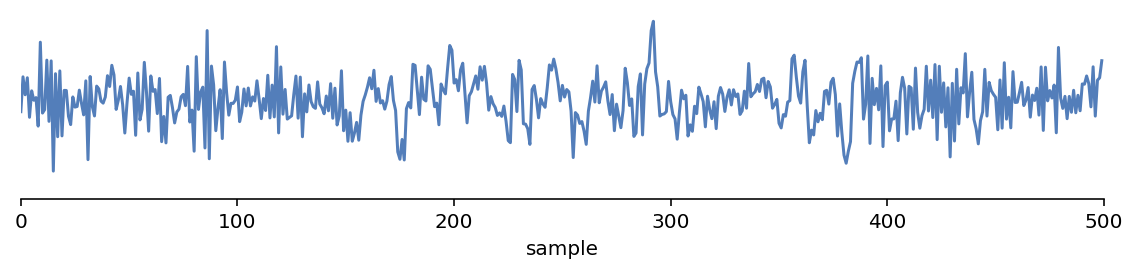

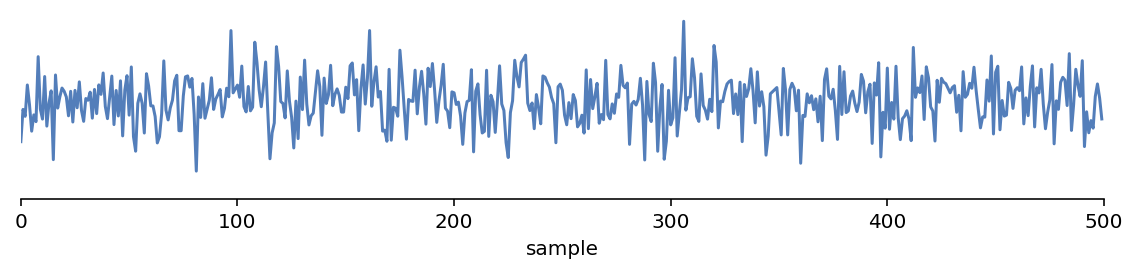

In [48]:
with FigureManager(figsize=(8, 2), sharex=True, despine_kws={"left": True}) as (
    fig1,
    ax1,
):
    ax1.plot(two_ar_short.sig)
    ax1.set_xlabel("sample")

    ax1.set_xlim(0, two_ar_short.n_samples)
    ax1.set_yticks([])

with FigureManager(figsize=(8, 2), sharex=True, despine_kws={"left": True}) as (
    fig2,
    ax2,
):
    crt_trans = np.hstack(([0], two_ar_short.transitions))
    shuf_sig = np.copy(two_ar_short.sig)
    rng = np.random.default_rng(1)
    for crt_t1, crt_t2 in zip(crt_trans, crt_trans[1:]):
        shuf_sig[crt_t1:crt_t2] = rng.permutation(shuf_sig[crt_t1:crt_t2])

    ax2.plot(shuf_sig)
    ax2.set_xlabel("sample")

    ax2.set_xlim(0, two_ar_short.n_samples)

    ax2.set_yticks([])

fig1.savefig(os.path.join(fig_path, "example_switching.pdf"), transparent=True)
fig2.savefig(os.path.join(fig_path, "example_switching_shuffled.pdf"), transparent=True)

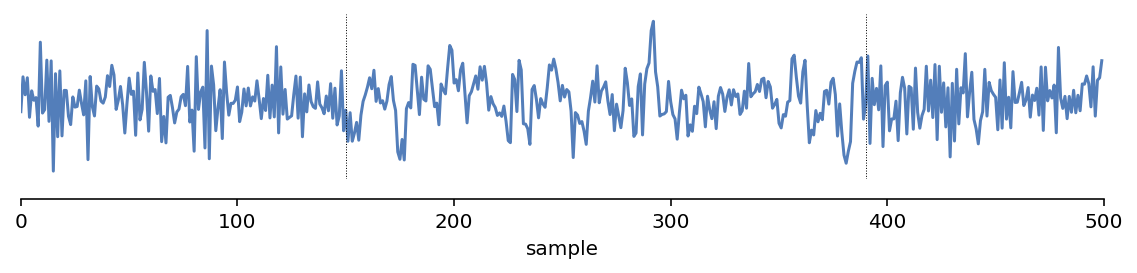

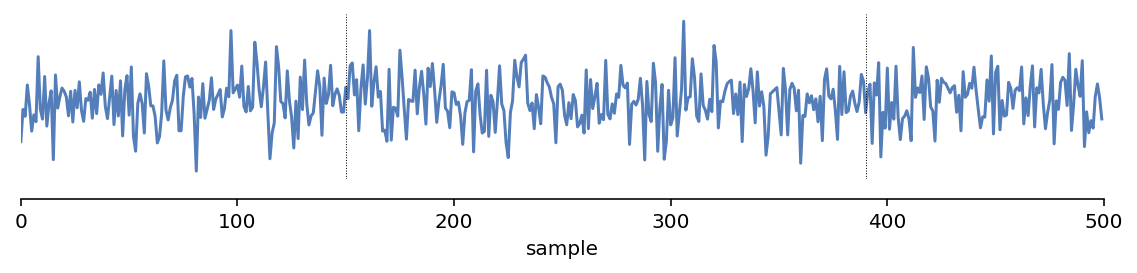

In [49]:
with FigureManager(figsize=(8, 2), sharex=True, despine_kws={"left": True}) as (
    fig1,
    ax1,
):
    ax1.plot(two_ar_short.sig)
    ax1.set_xlabel("sample")

    ax1.set_xlim(0, two_ar_short.n_samples)
    ax1.set_yticks([])

    show_latent(two_ar_short.usage_seq, show_bars=False, ax=ax1)

with FigureManager(figsize=(8, 2), sharex=True, despine_kws={"left": True}) as (
    fig2,
    ax2,
):
    crt_trans = np.hstack(([0], two_ar_short.transitions))
    shuf_sig = np.copy(two_ar_short.sig)
    rng = np.random.default_rng(1)
    for crt_t1, crt_t2 in zip(crt_trans, crt_trans[1:]):
        shuf_sig[crt_t1:crt_t2] = rng.permutation(shuf_sig[crt_t1:crt_t2])

    ax2.plot(shuf_sig)
    ax2.set_xlabel("sample")

    ax2.set_xlim(0, two_ar_short.n_samples)

    show_latent(two_ar_short.usage_seq, show_bars=False, ax=ax2)

    ax2.set_yticks([])

fig1.savefig(os.path.join(fig_path, "example_switching_vlines.pdf"), transparent=True)
fig2.savefig(os.path.join(fig_path, "example_switching_shuffled_vlines.pdf"), transparent=True)

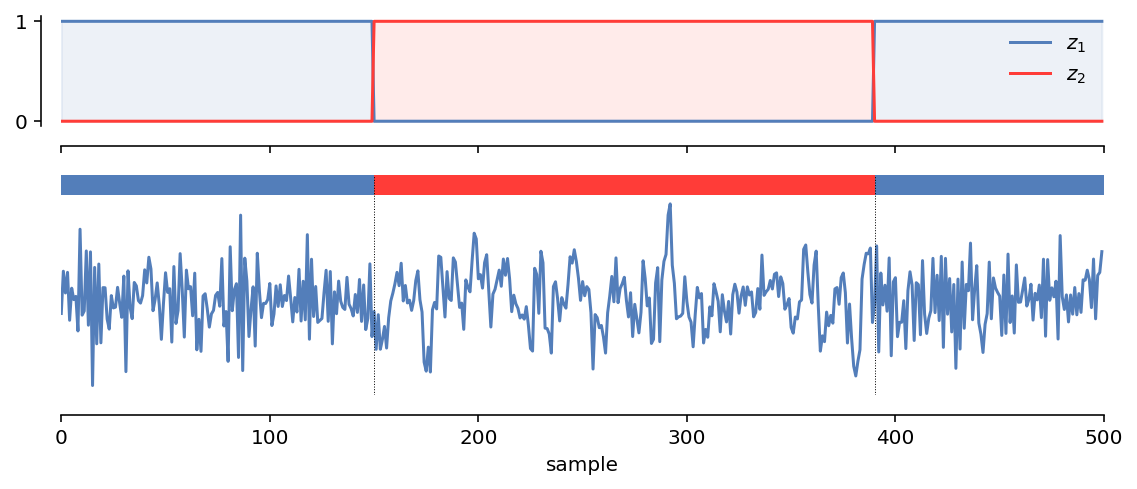

In [50]:
with FigureManager(
    2, 1, figsize=(8, 3.5), sharex=True, gridspec_kw={"height_ratios": (1, 2)}
) as (
    fig1,
    (ax0, ax1),
):
    ax0.plot(two_ar_short.usage_seq == 0, "C0", label="$z_1$")
    ax0.plot(two_ar_short.usage_seq == 1, "C1", label="$z_2$")

    ax0.fill_between(
        np.arange(two_ar_short.n_samples),
        two_ar_short.usage_seq == 0,
        color="C0",
        alpha=0.1,
    )
    ax0.fill_between(
        np.arange(two_ar_short.n_samples),
        two_ar_short.usage_seq == 1,
        color="C1",
        alpha=0.1,
    )
    ax0.legend(frameon=False)

    ax1.plot(two_ar_short.sig)
    ax1.set_xlabel("sample")

    ax1.set_xlim(0, two_ar_short.n_samples)
    ax1.set_yticks([])

    show_latent(two_ar_short.usage_seq, ax=ax1)

sns.despine(left=True, ax=ax1)
fig1.savefig(
    os.path.join(fig_path, "example_switching_vlines_bars.pdf"), transparent=True
)

Accuracy score in this interval: 0.95.


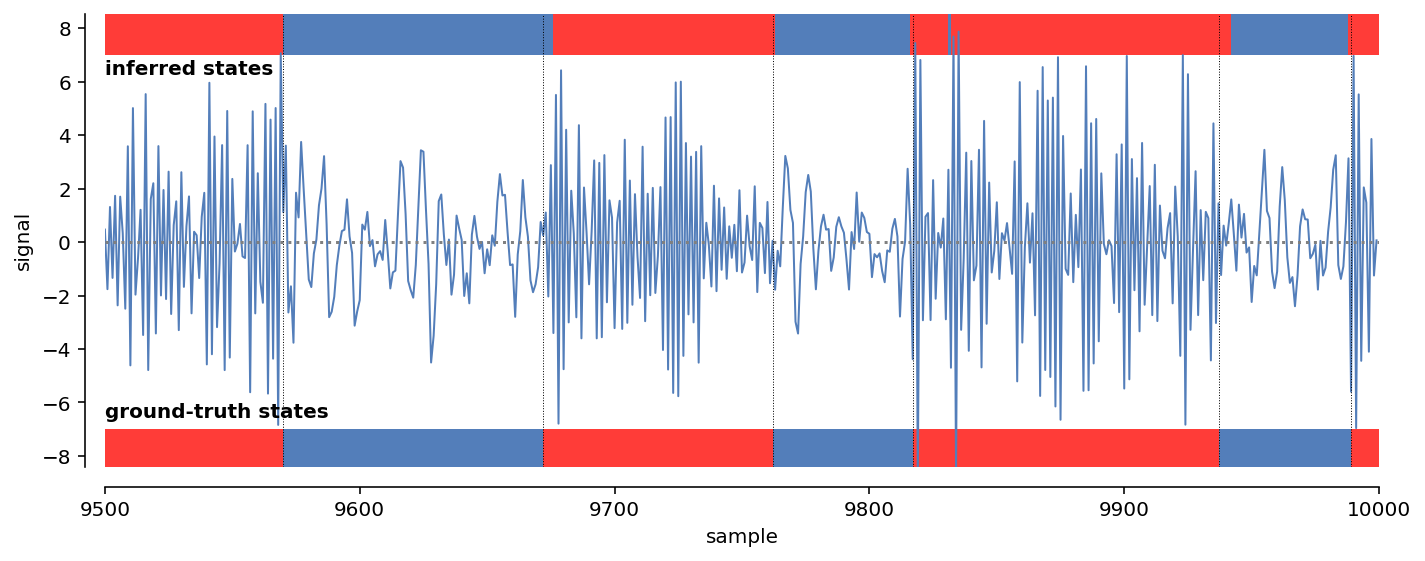

In [51]:
with FigureManager(figsize=(10, 4)) as (fig, ax):
    crt_dataset = two_ar3.dataset[idx]
    crt_n = len(crt_dataset.y)
    #  crt_range = slice(crt_n - 500, crt_n)
    crt_range = slice(9500, 10000)
    ax.plot(
        np.arange(crt_range.start, crt_range.stop),
        two_ar3.dataset[idx].y[crt_range],
        lw=1.0,
    )
    ax.axhline(0, c="gray", ls=":")
    ax.set_xlim(crt_range.start, crt_range.stop)
    ax.set_ylim(-7, 7)

    ax.set_xlabel("sample")
    ax.set_ylabel("signal")

    show_latent(crt_dataset.usage_seq, bar_location="bottom")

    crt_history = two_ar3.result_cepstral[1].history[idx]
    show_latent(np.argmax(crt_history.r, axis=1), show_vlines=False)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

crt_mean = np.mean(
    crt_dataset.usage_seq[
        crt_range.start + two_ar3.n_features : crt_range.stop + two_ar3.n_features
    ]
    == np.argmax(crt_history.r, axis=1)[crt_range]
)
print(f"Accuracy score in this interval: {crt_mean:.2f}.")

fig.savefig(os.path.join(fig_path, "example_2x_ar3_short_cepstral.pdf"))